# Импорт

In [2]:
import pandas as pd
import torch
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.metrics import classification_report

from sklearn.preprocessing import MaxAbsScaler
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
import sweetviz as sv
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE

from sklearn.neighbors import KNeighborsClassifier
import numpy as np
import torchmetrics

c:\Users\Mike\Desktop\5semak\NLP_5_semak\NLP\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\Mike\Desktop\5semak\NLP_5_semak\NLP\lib\site-packages\torchaudio\backend\utils.py:74: UserWarning: No audio backend is available.
  warnings.warn("No audio backend is available.")


# Загрузка датасета

In [81]:
data = pd.read_csv('../Data/neo_task.csv')
data


,id,name,est_diameter_min,est_diameter_max,relative_velocity,miss_distance,absolute_magnitude,hazardous
0,3561024.0,(2011 GZ2),0.016016,0.035813,56014.078517,1.024333e+06,26.10,False
1,54016766.0,(2020 HT6),0.030518,0.068240,7864.348060,3.268186e+07,24.70,False
2,3746620.0,(2016 ED156),0.055533,0.124177,55257.544508,6.538636e+07,23.40,False
3,3633054.0,(2013 FD8),0.019256,0.043057,41531.404722,1.260796e+07,25.70,False
4,3742124.0,(2016 CW31),0.139494,0.311918,67639.394481,7.130590e+07,21.40,False
...,...,...,...,...,...,...,...,...
90831,54231436.0,(2021 YE),0.017561,0.039268,23264.740825,1.635007e+06,25.90,False
90832,3824972.0,(2018 KL),0.110804,0.247765,24802.519406,3.351901e+07,21.90,False
90833,3740101.0,(2016 AB166),0.035039,0.078350,116288.999548,5.471396e+07,24.40,False
90834,3691093.0,(2014 SQ260),0.044112,0.098637,45763.317060,2.694877e+07,23.90,False


# Преобразование датасета

In [82]:
not_important_col = ['id', 'name']
class_column = 'hazardous'


In [83]:
data_with_only_important_col = data.drop(not_important_col, axis=1)
data_wo_nan = data_with_only_important_col.dropna()
data_with_only_important_col_wo_classes = data_wo_nan.drop(class_column, axis=1)
classes = data_wo_nan[class_column]


Feature: est_diameter_min                    |█▍        | [ 14%]   00:00 -> (00:00 left)

Done! Use 'show' commands to display/save.   |██████████| [100%]   00:01 -> (00:00 left)



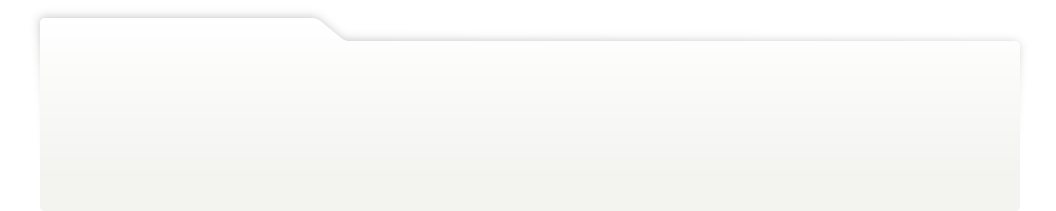
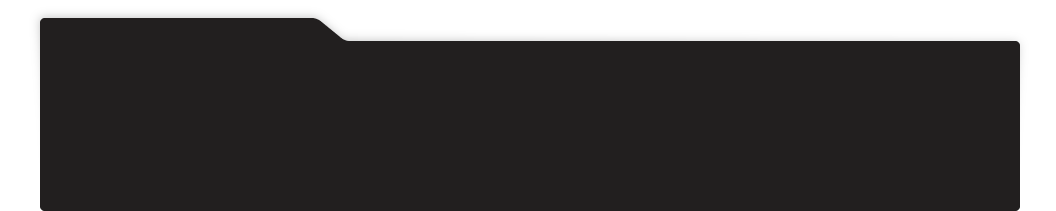
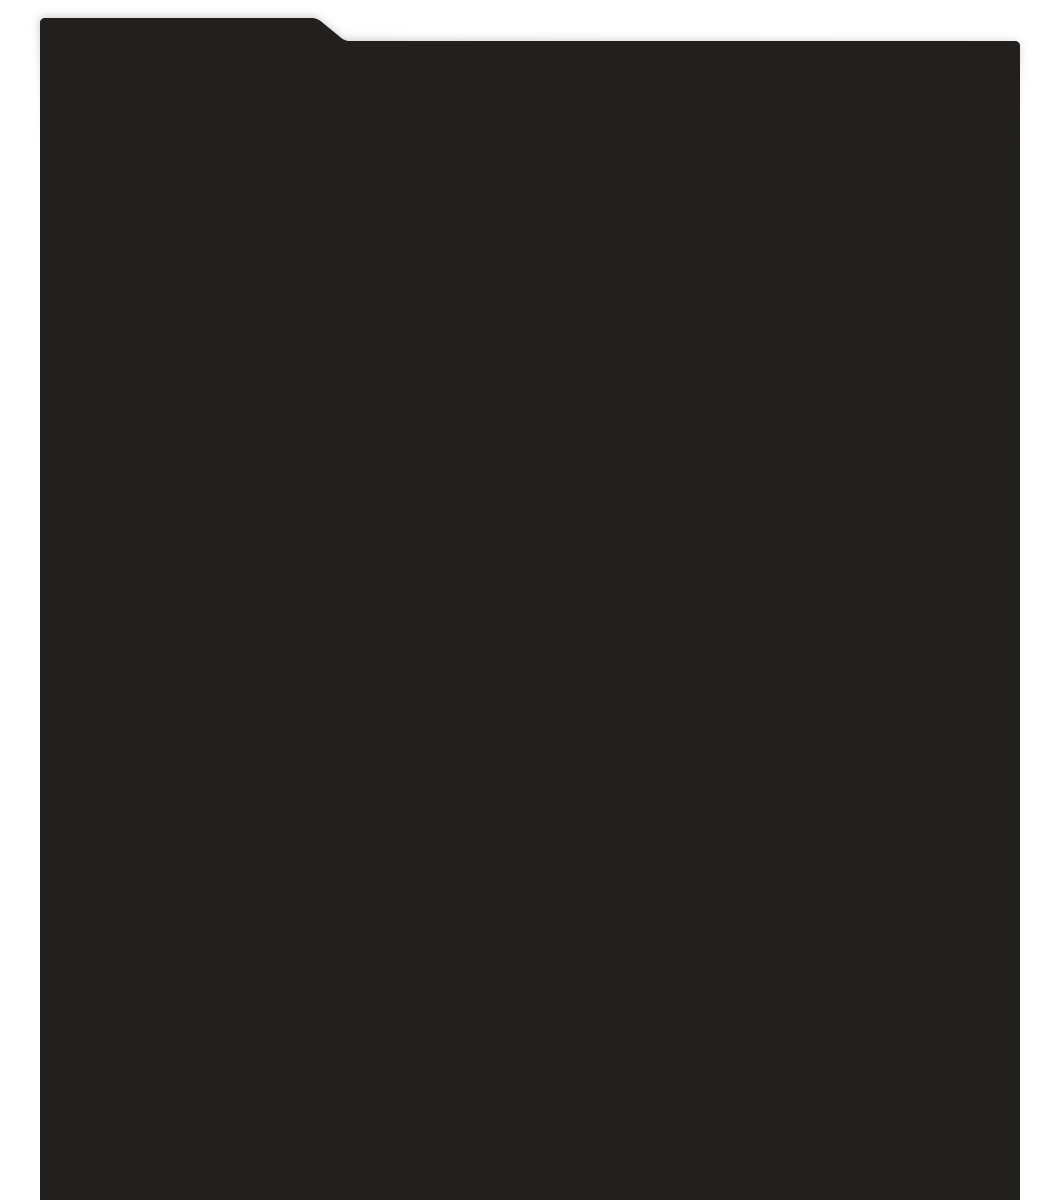
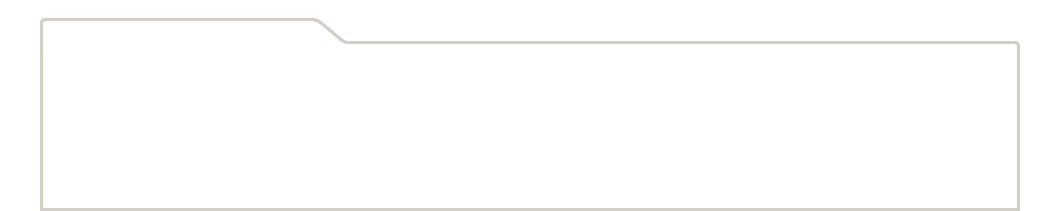
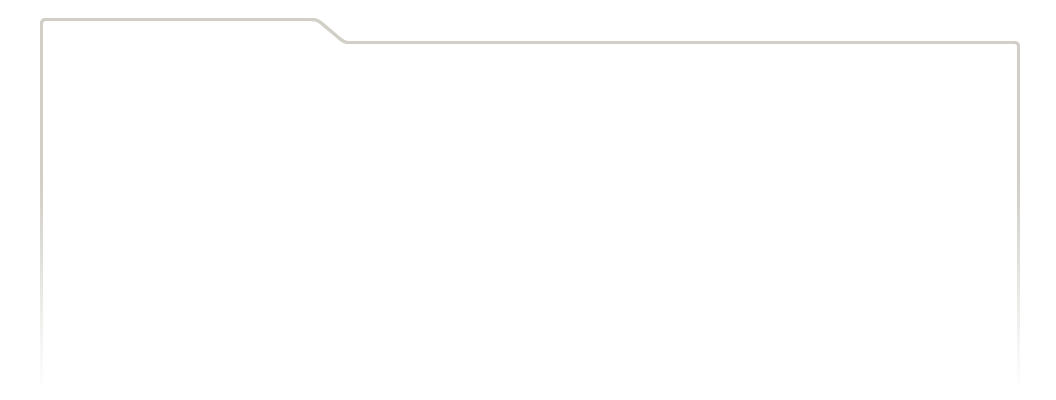
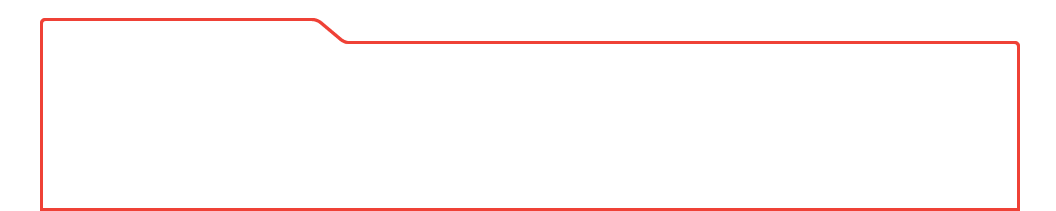
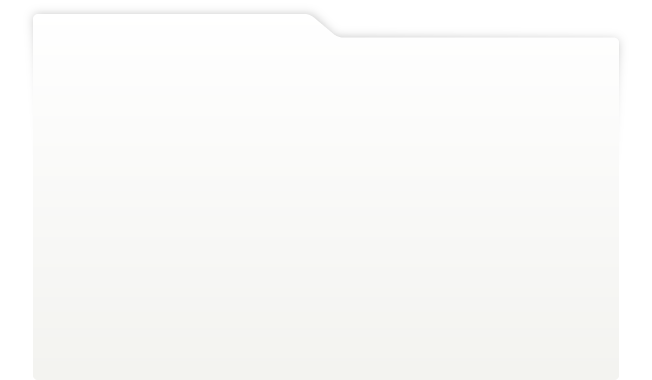
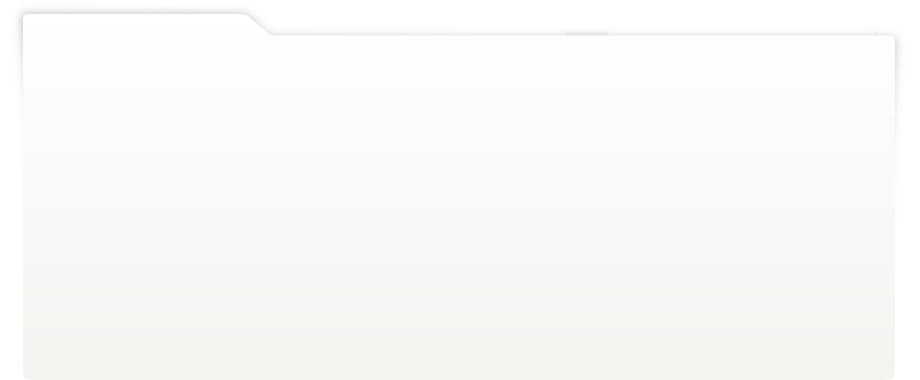
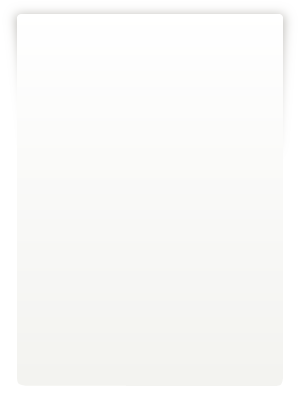
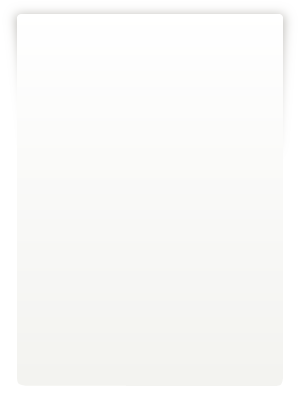
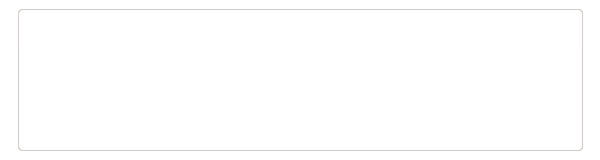
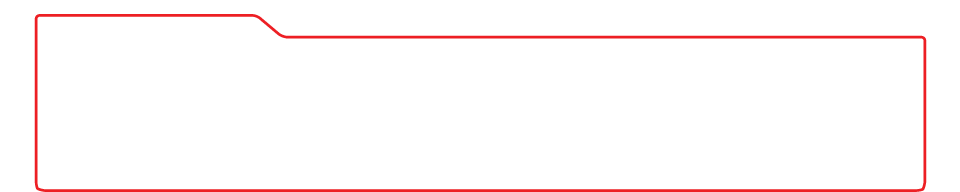
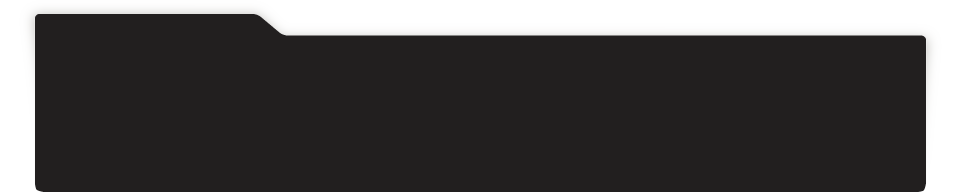
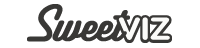
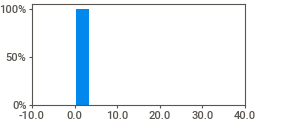
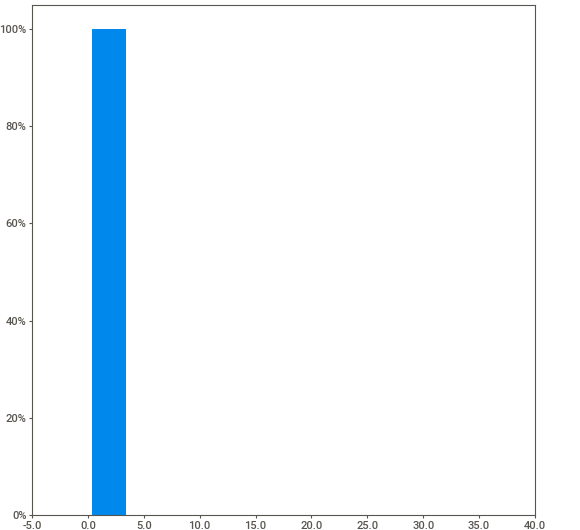
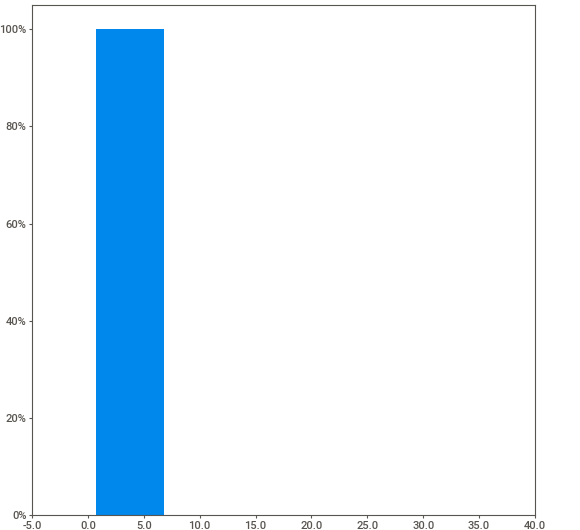
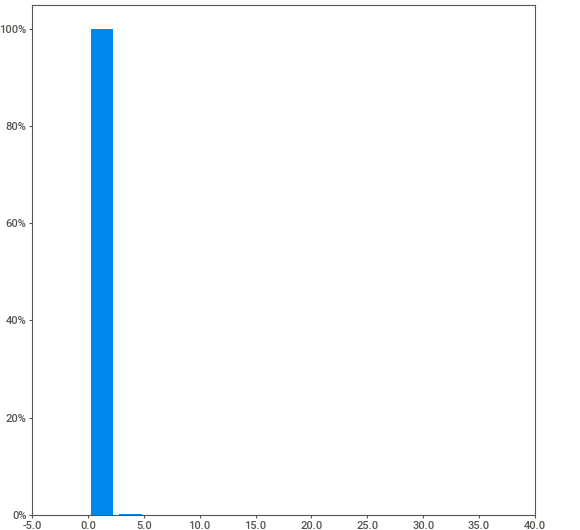
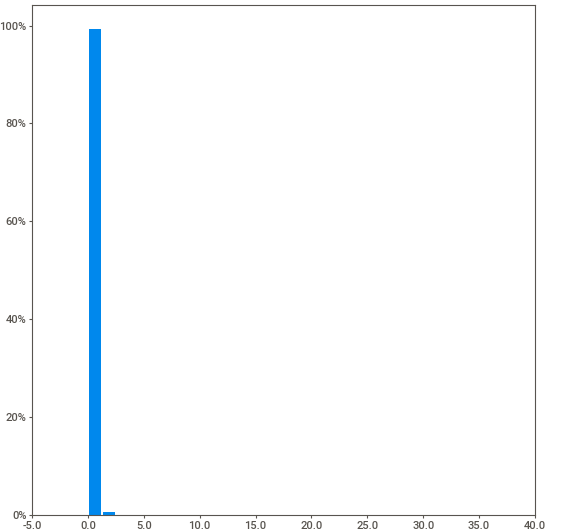
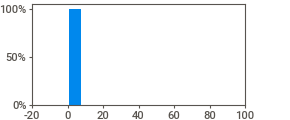
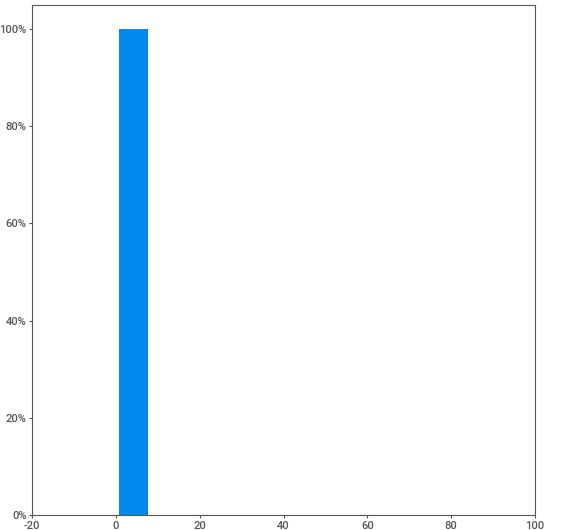
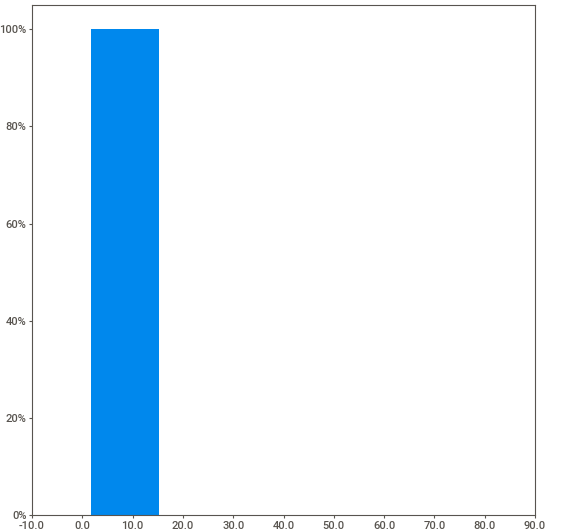
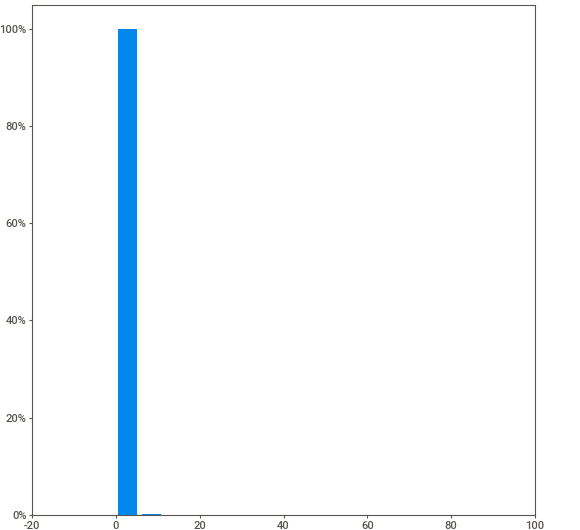
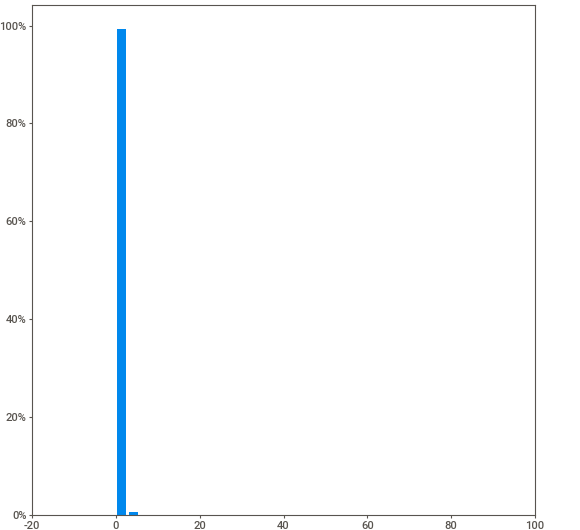
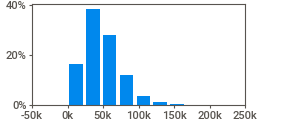
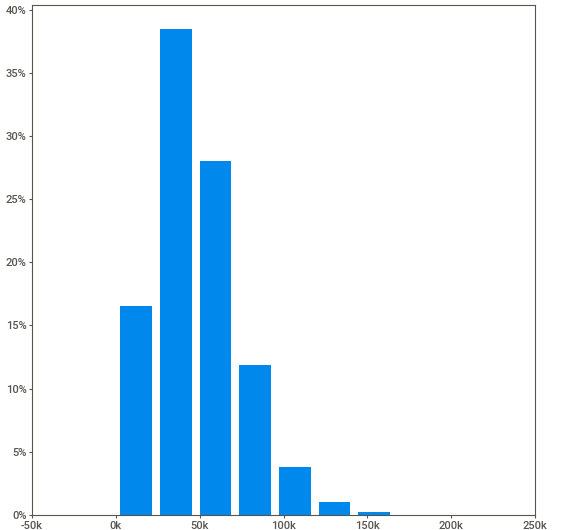
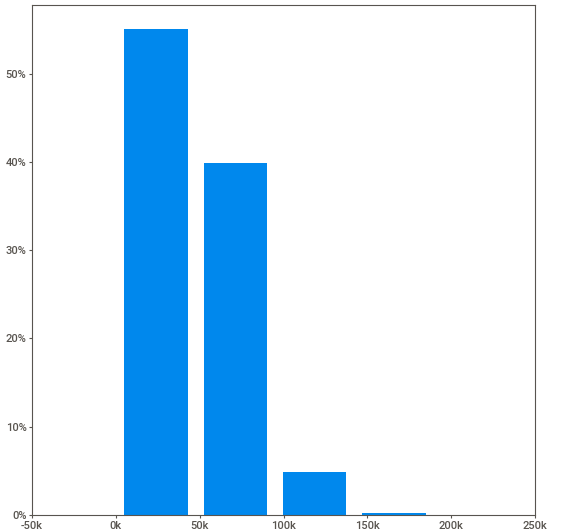
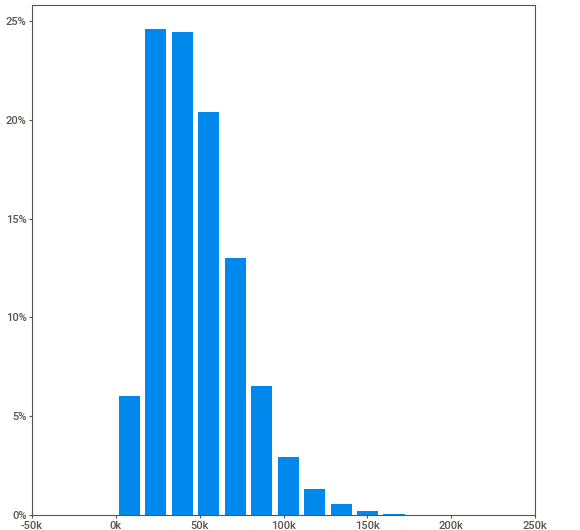
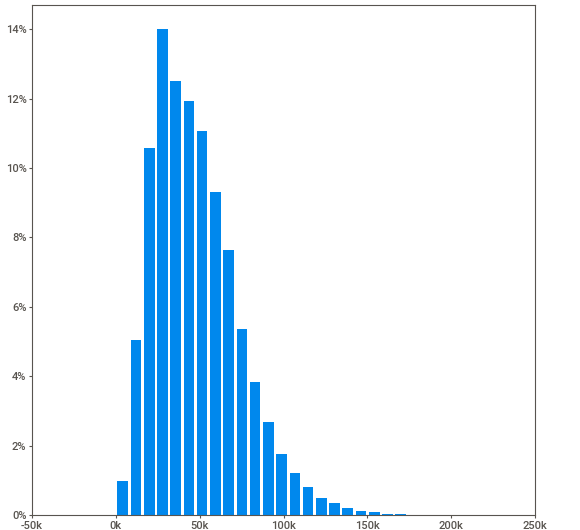
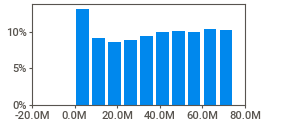
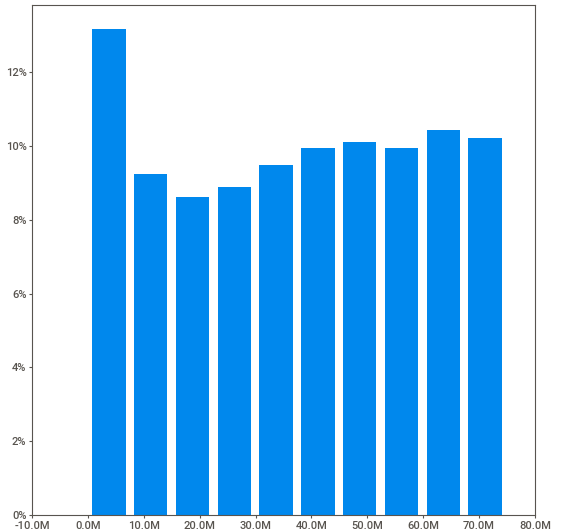
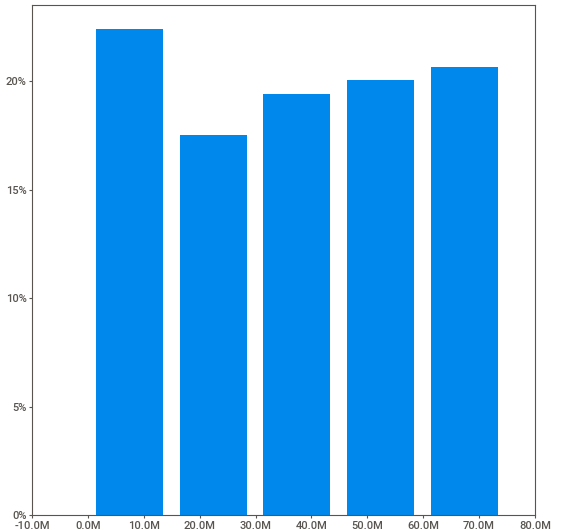
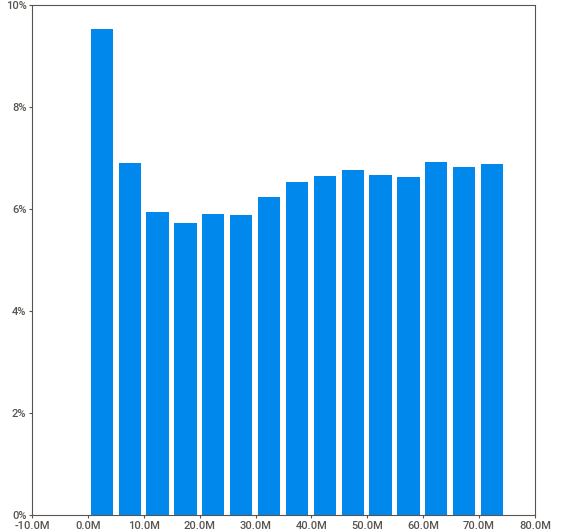
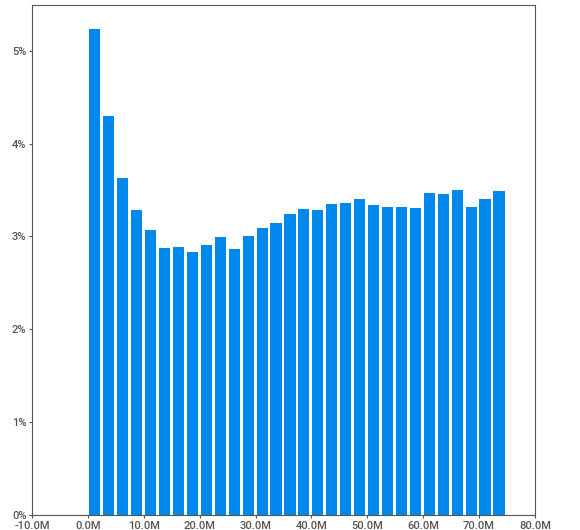
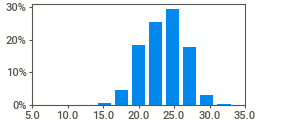
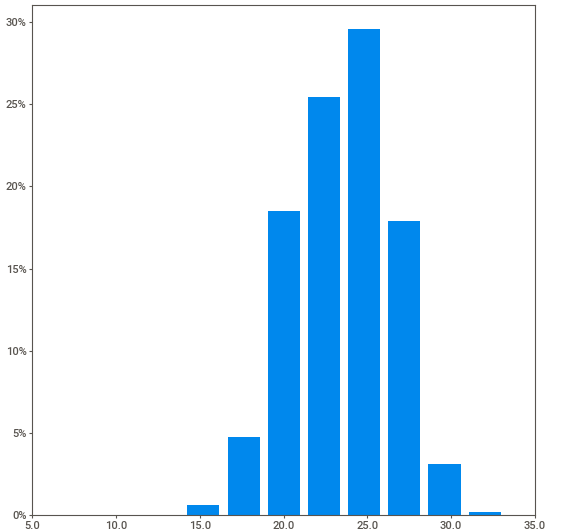
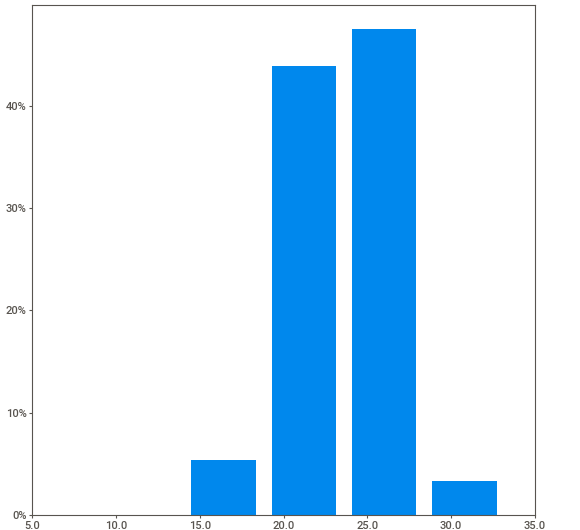
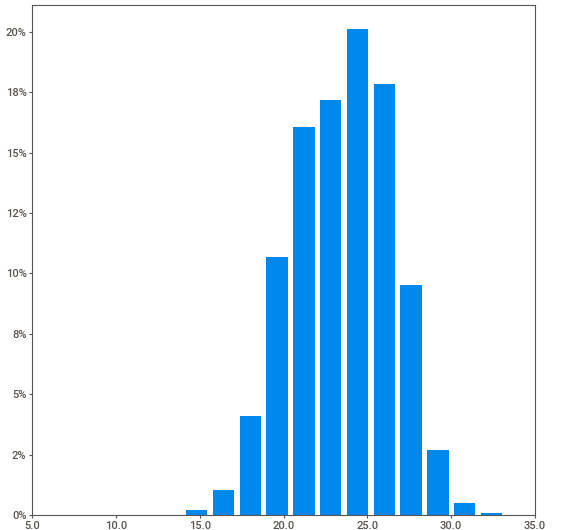
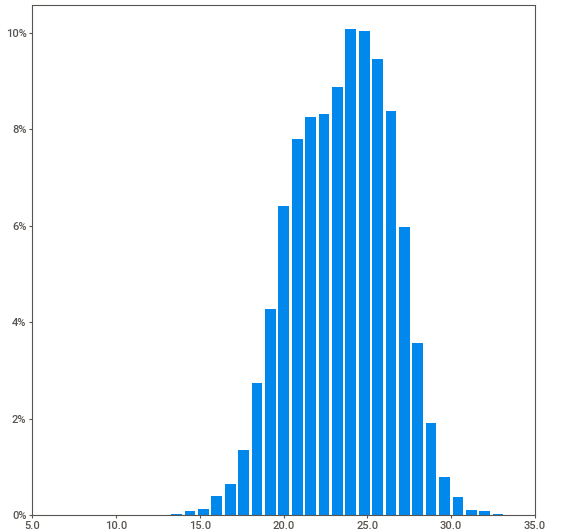
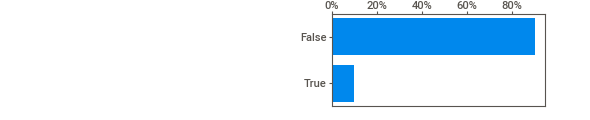
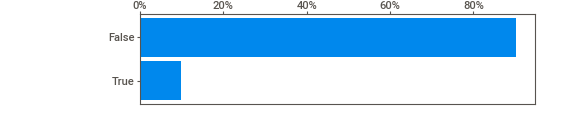
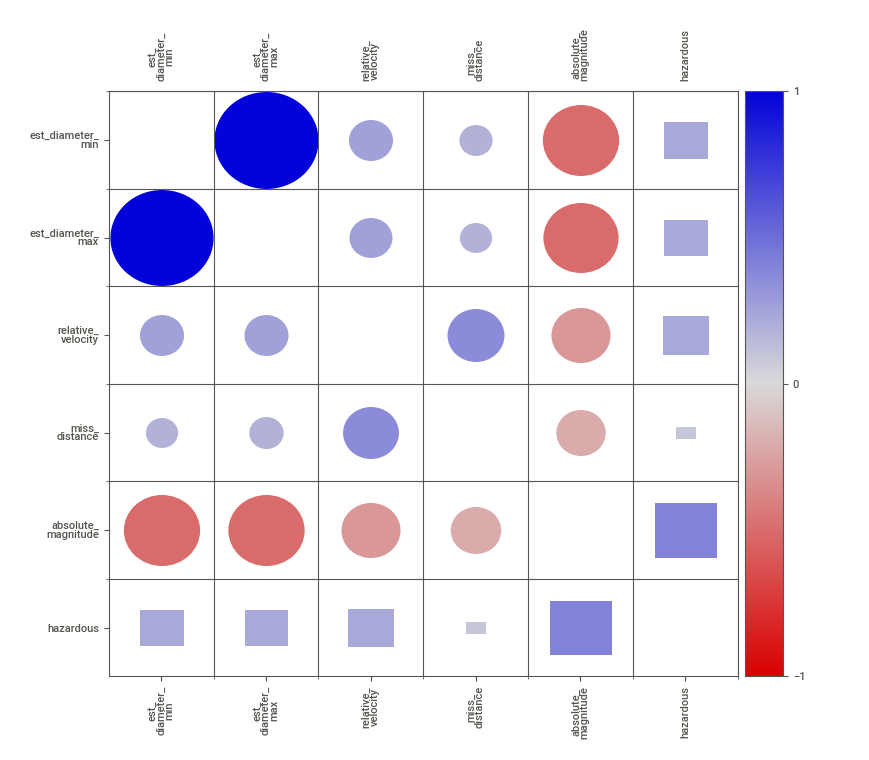
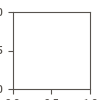

In [84]:
sv.analyze(data_wo_nan).show_notebook()


# Нормализация + upper/under sampling

In [85]:
x = MaxAbsScaler()
x = x.fit(data_with_only_important_col_wo_classes)

norm_data = x.transform(data_with_only_important_col_wo_classes)
norm_data = pd.DataFrame(norm_data, columns=data_with_only_important_col_wo_classes.columns)

norm_data_with_classes_under_samled, classes_under_sampled = RandomUnderSampler().fit_resample(norm_data, classes)
norm_data_with_classes_upper_samled, classes_upper_sampled = SMOTE().fit_resample(norm_data, classes)


Feature: est_diameter_min                    |█▋        | [ 17%]   00:00 -> (00:00 left)

Done! Use 'show' commands to display/save.   |██████████| [100%]   00:01 -> (00:00 left)



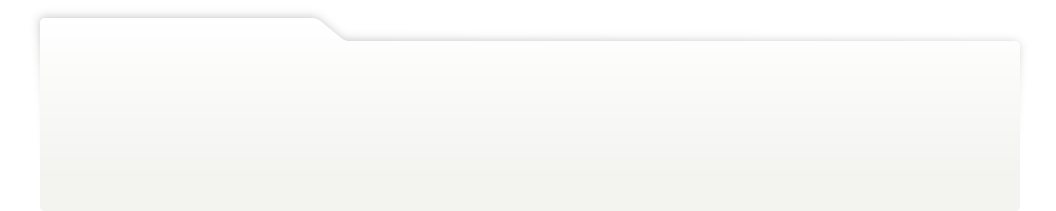
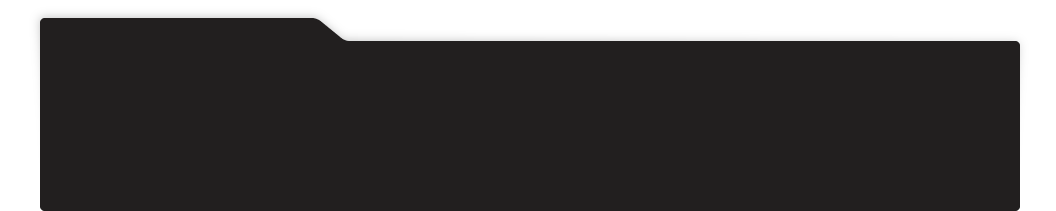
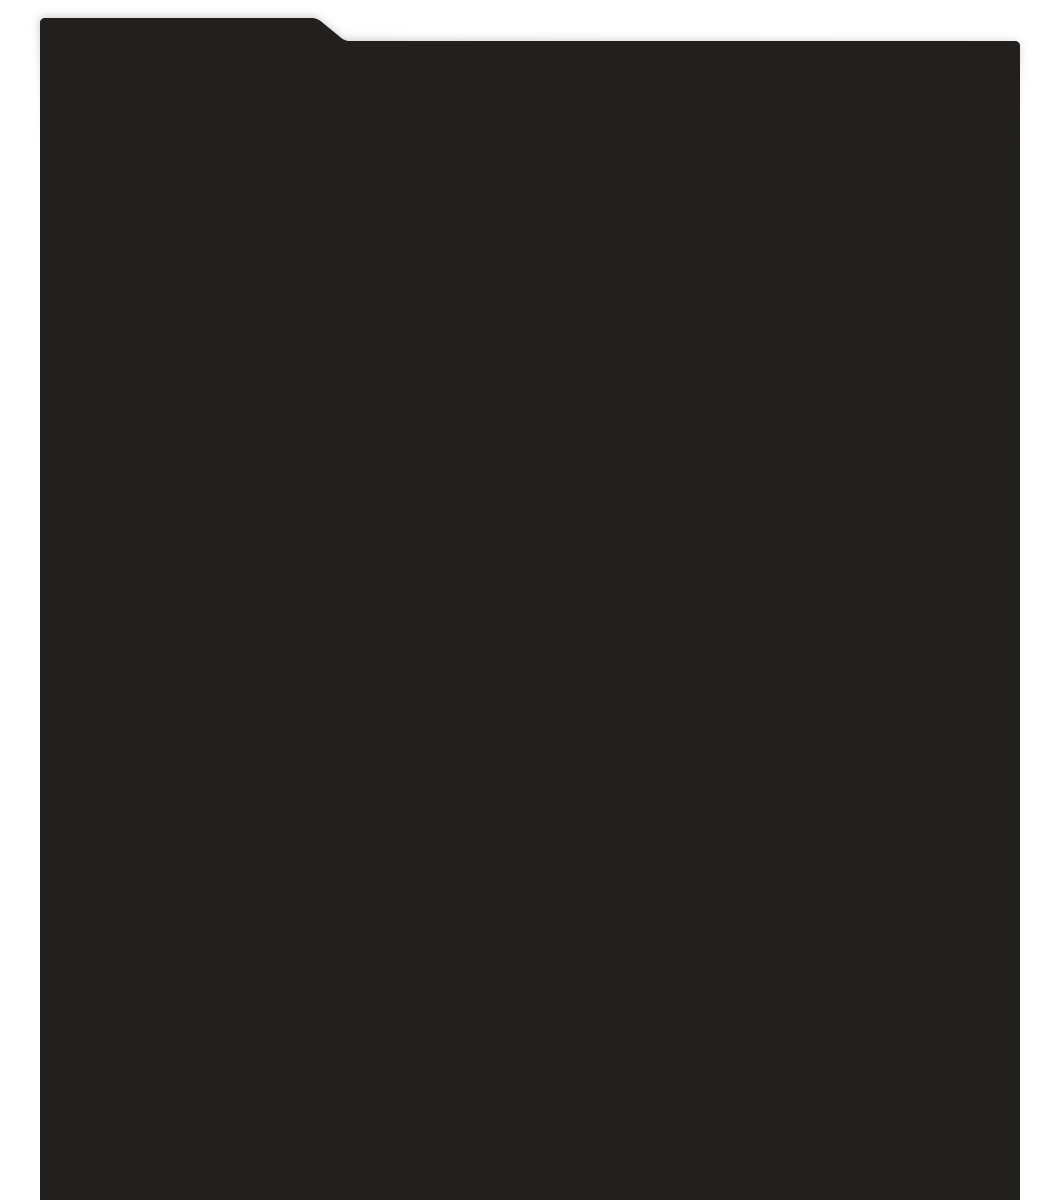
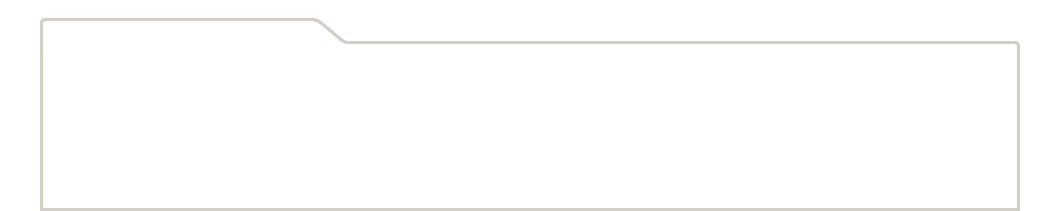
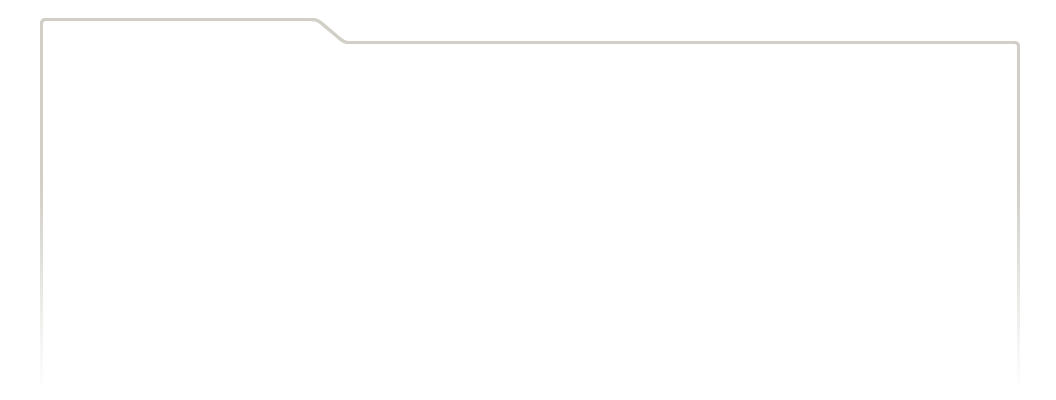
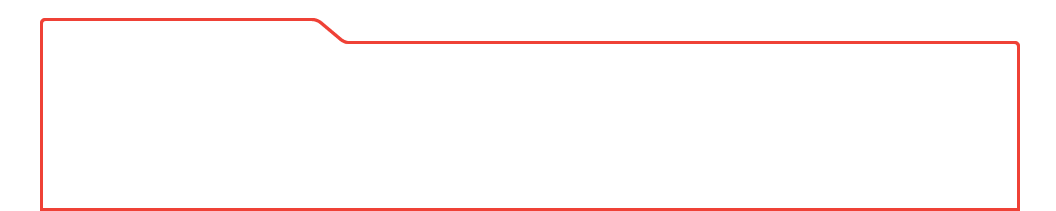
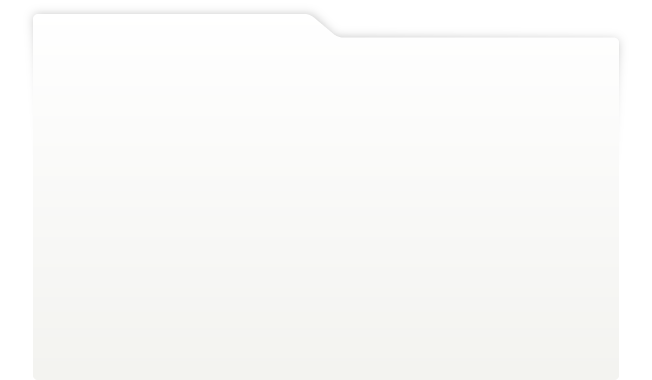
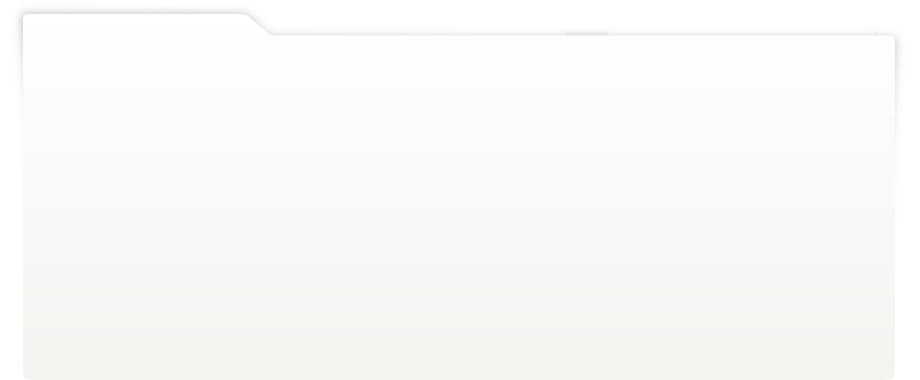
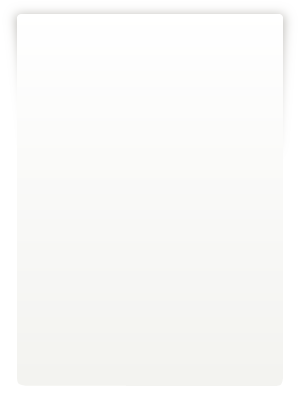
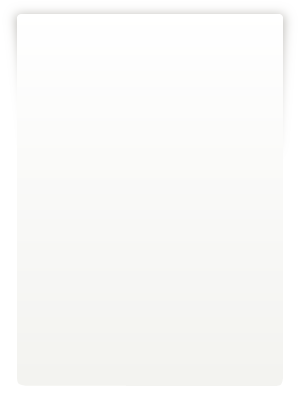
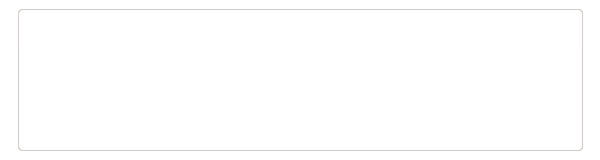
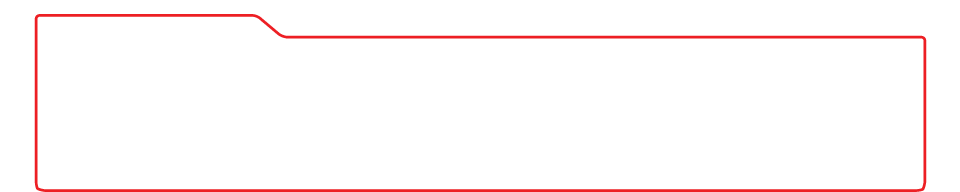
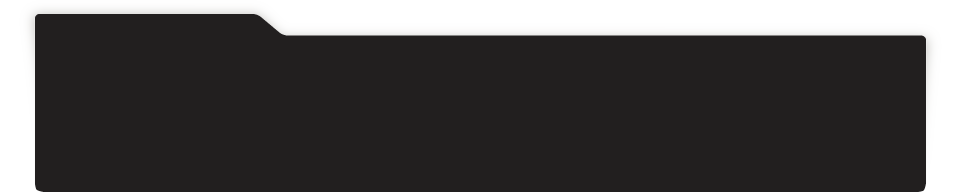
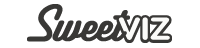
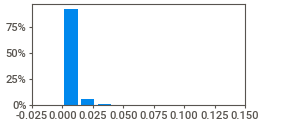
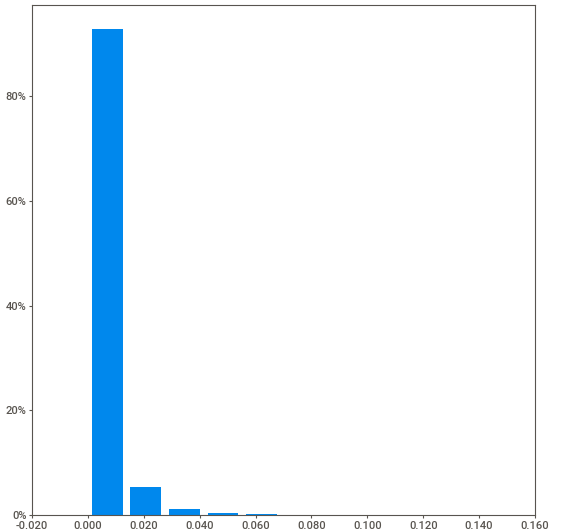
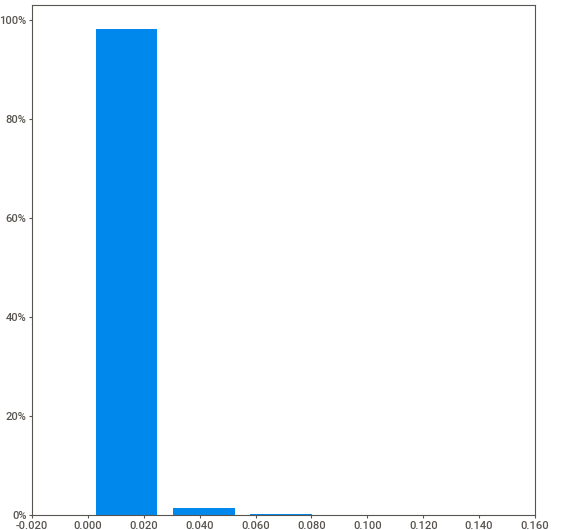
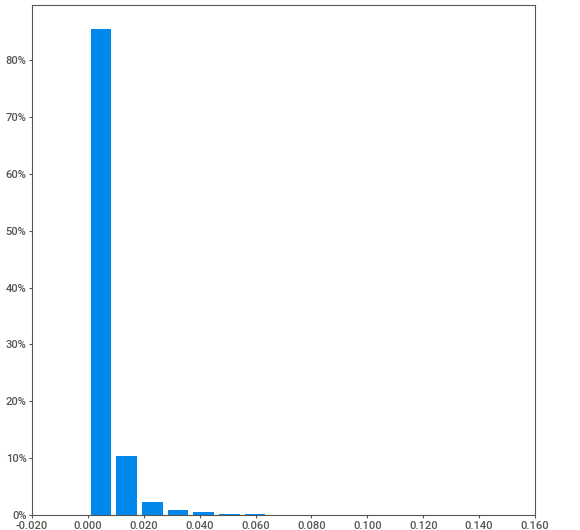
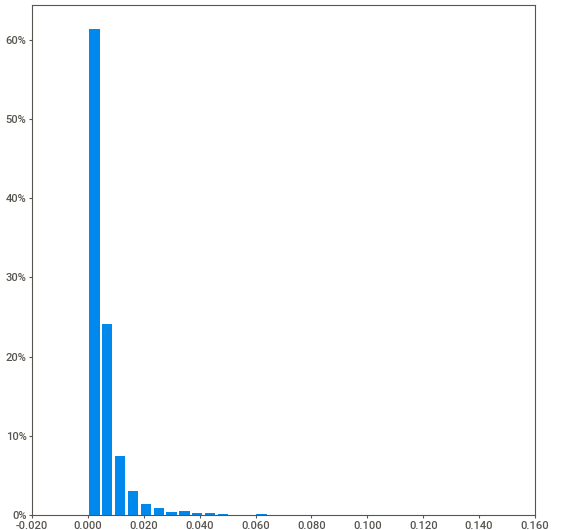
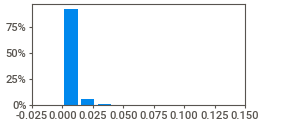
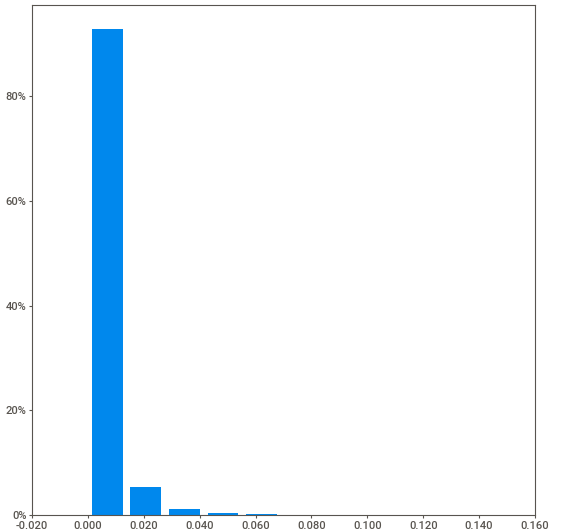
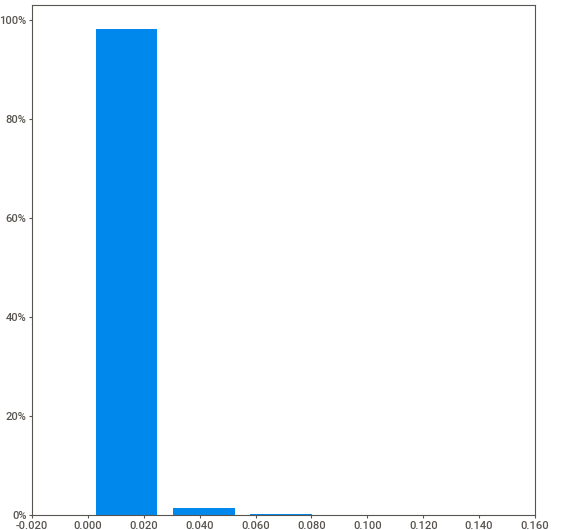
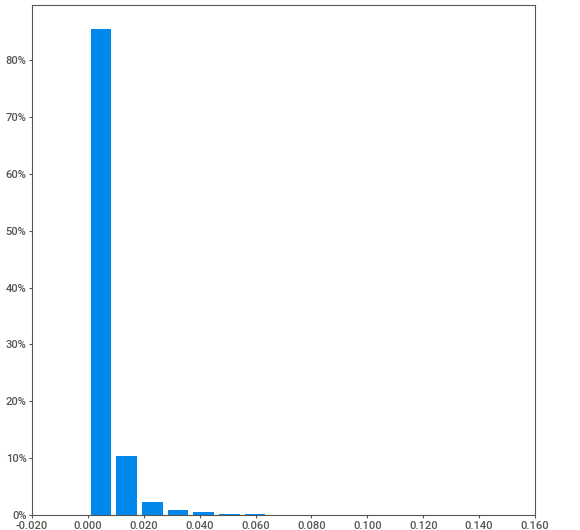
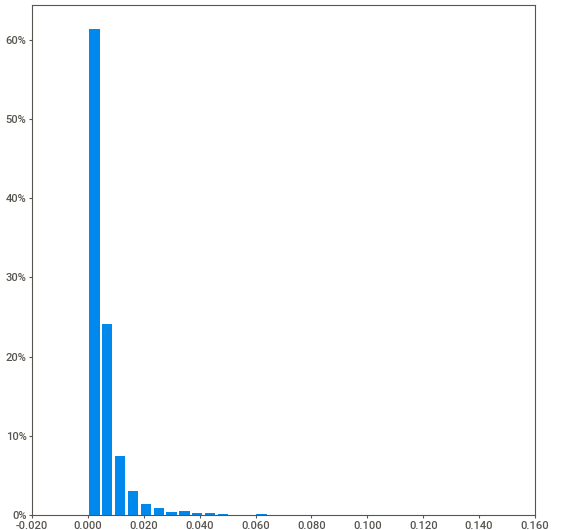
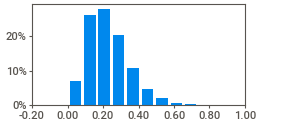
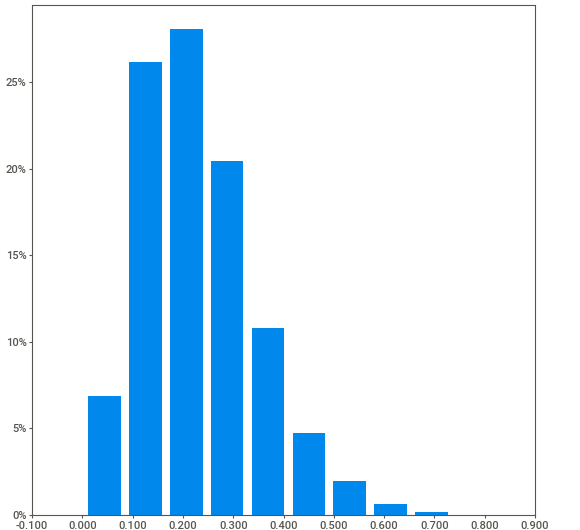
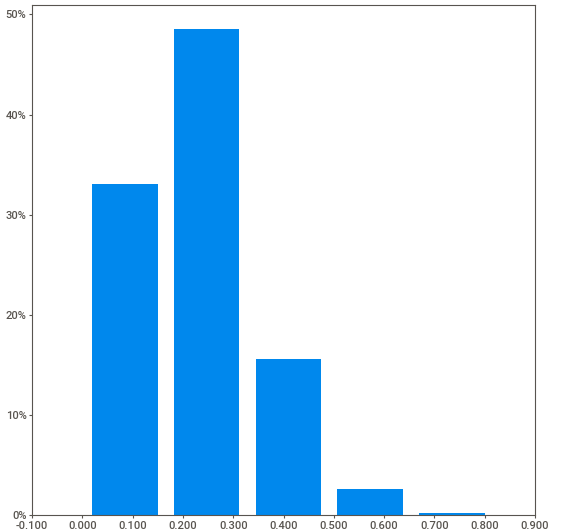
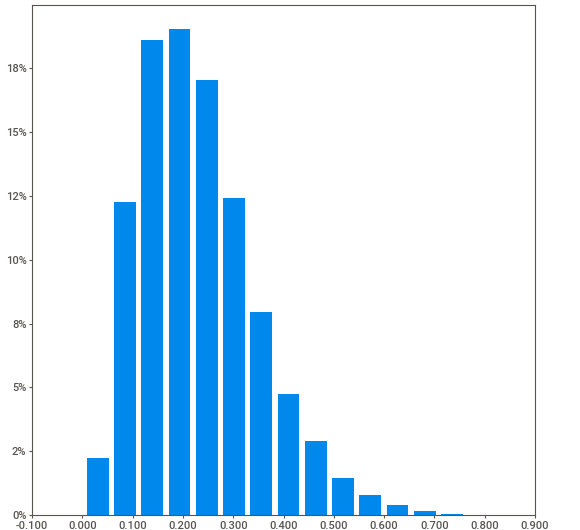
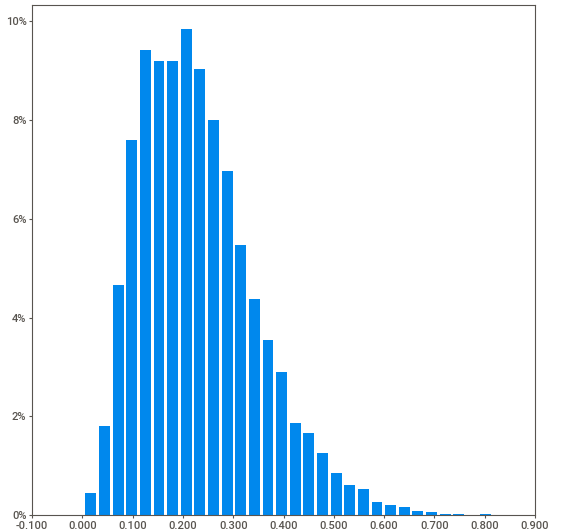
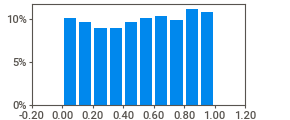
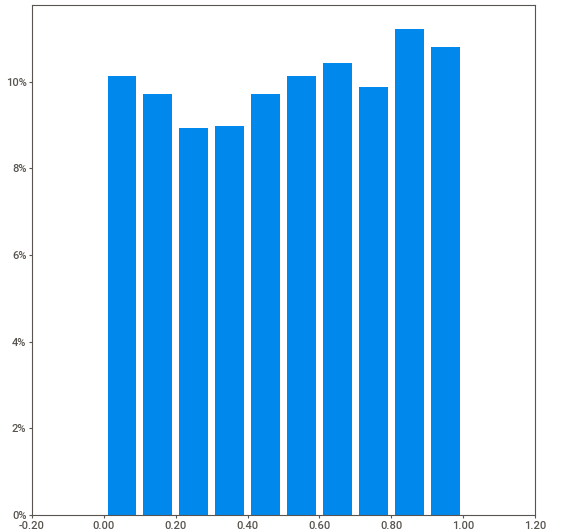
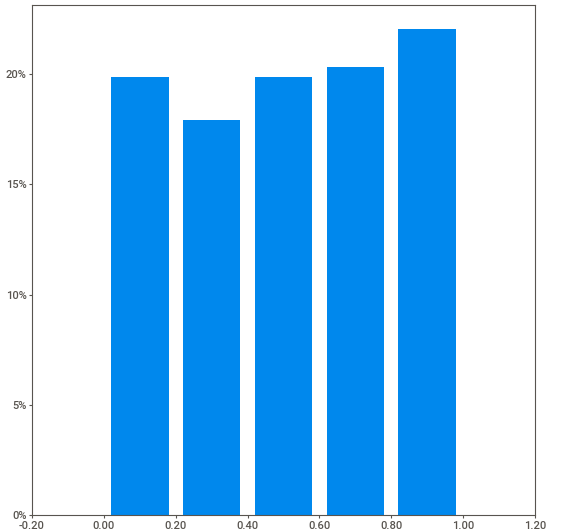
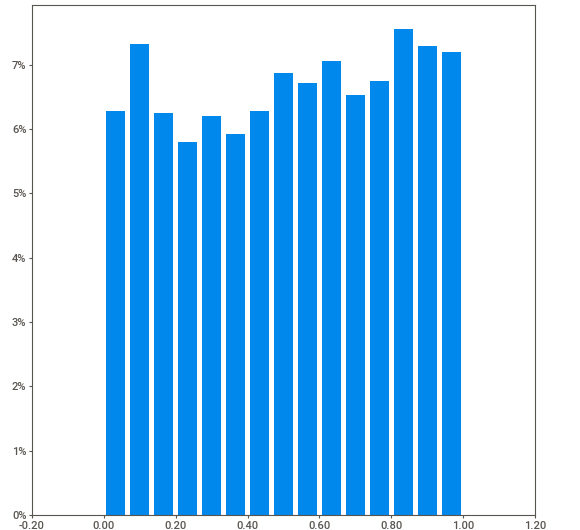
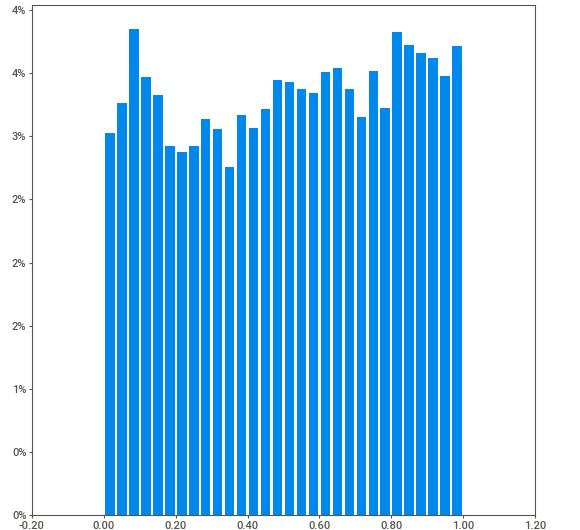
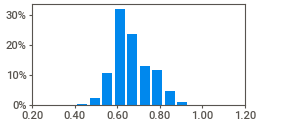
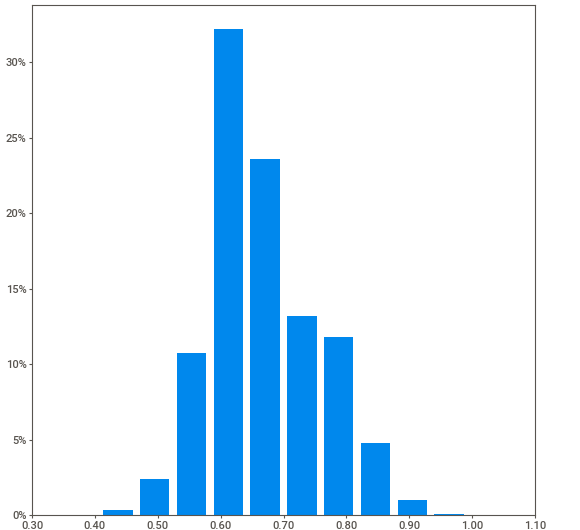
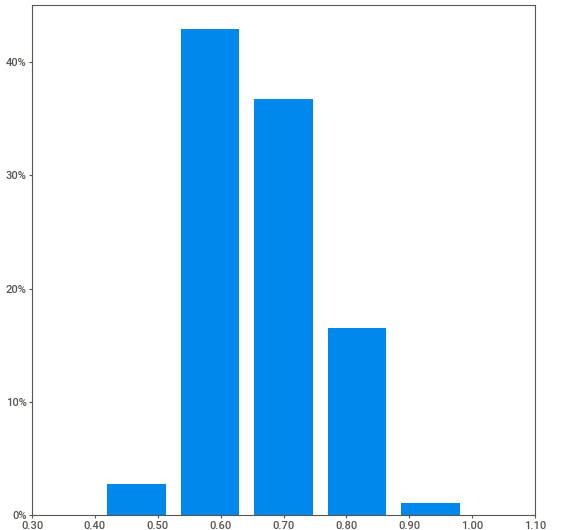
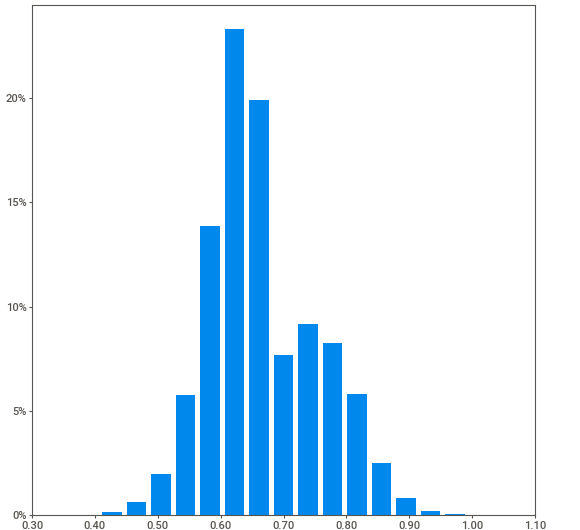
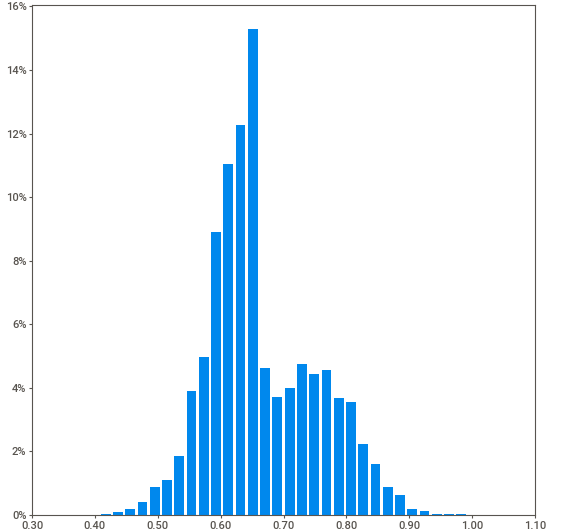
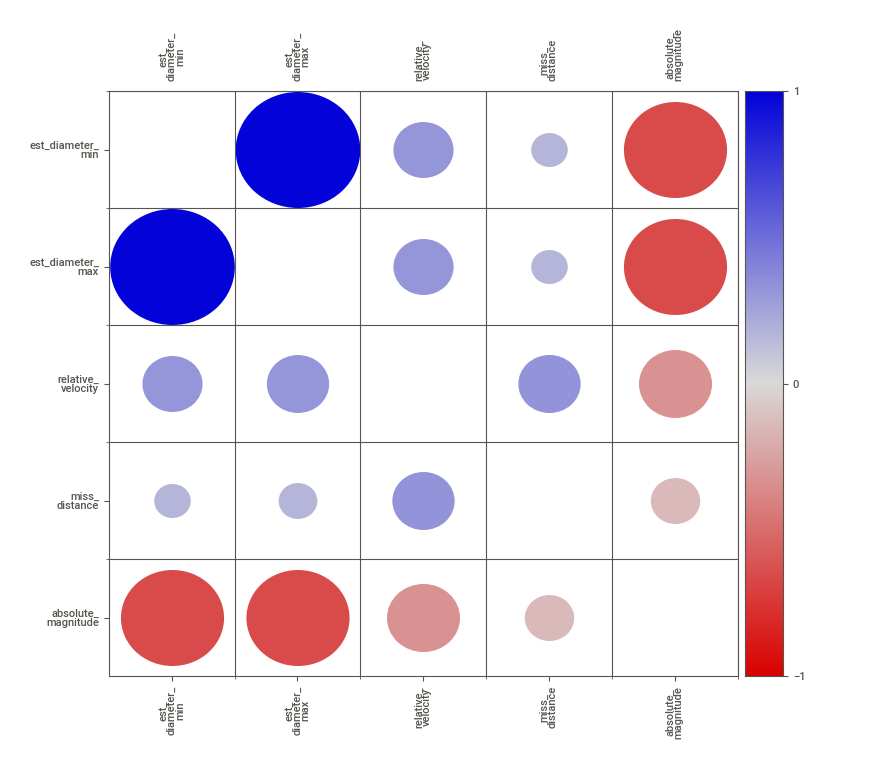
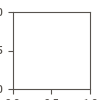

In [86]:
sv.analyze(norm_data_with_classes_under_samled).show_notebook()


Done! Use 'show' commands to display/save.   |██████████| [100%]   00:01 -> (00:00 left)



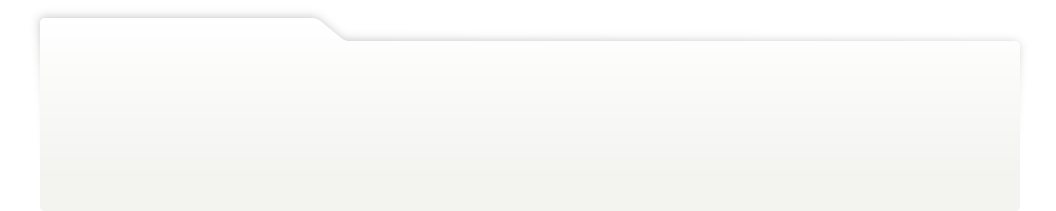
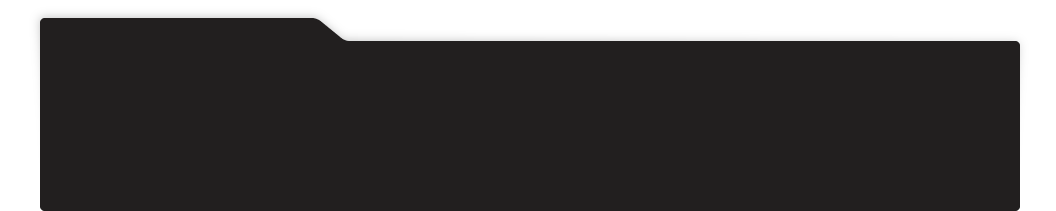
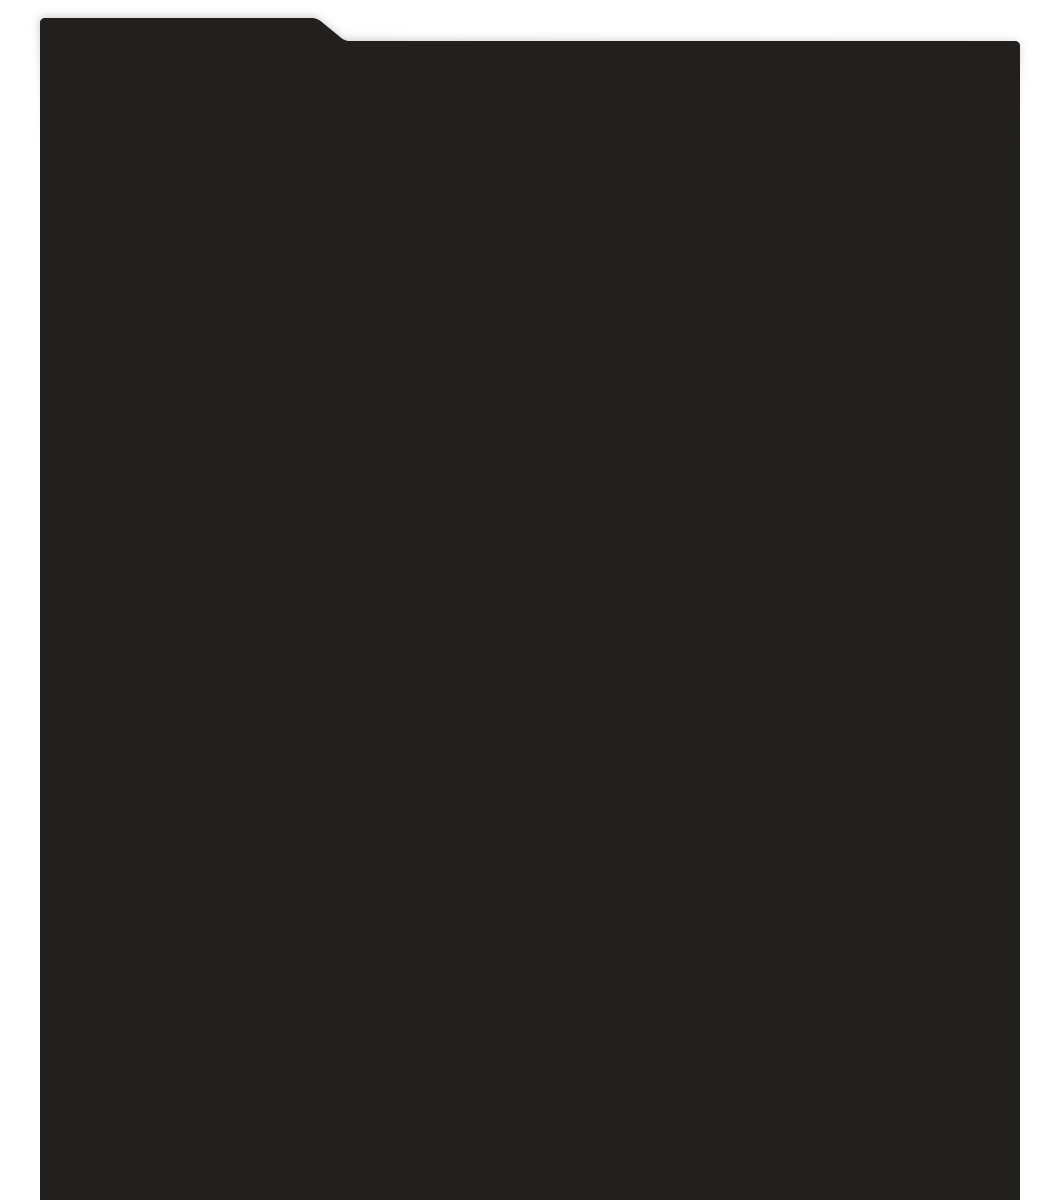
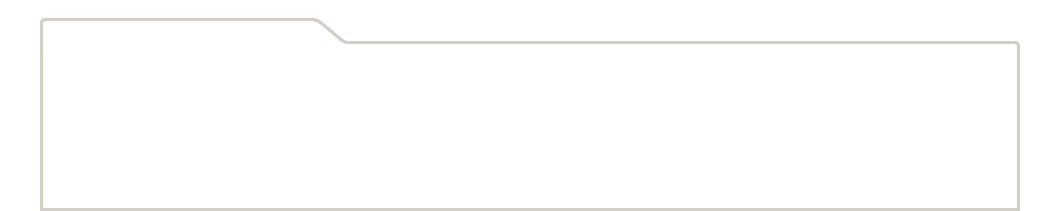
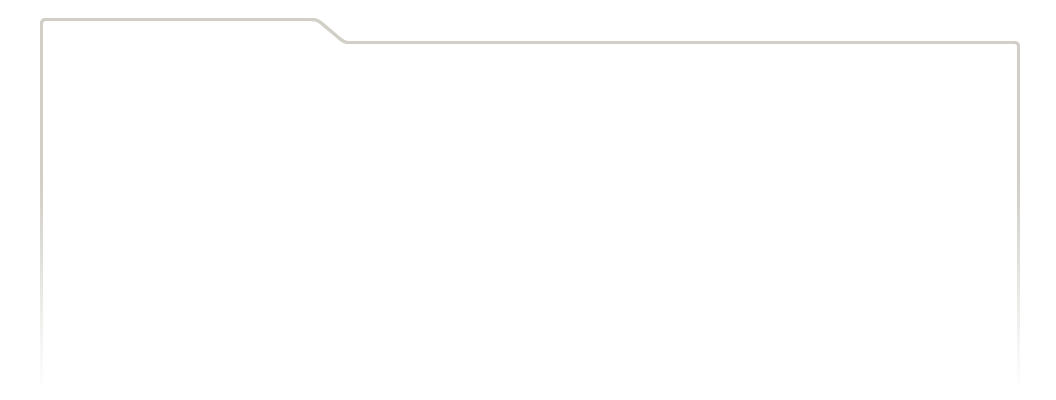
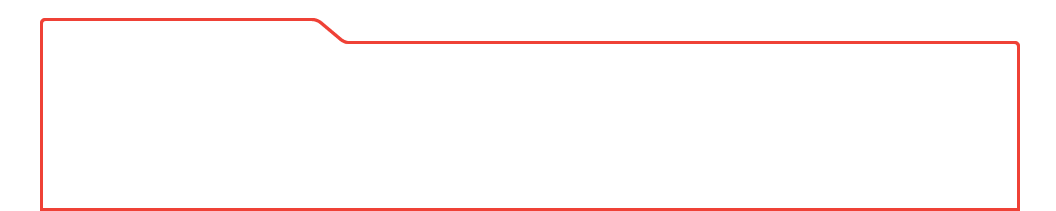
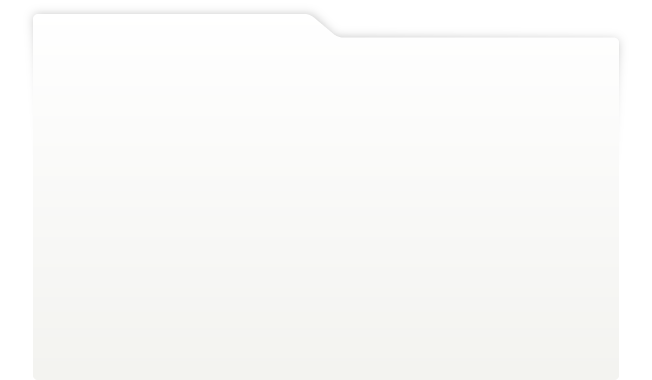
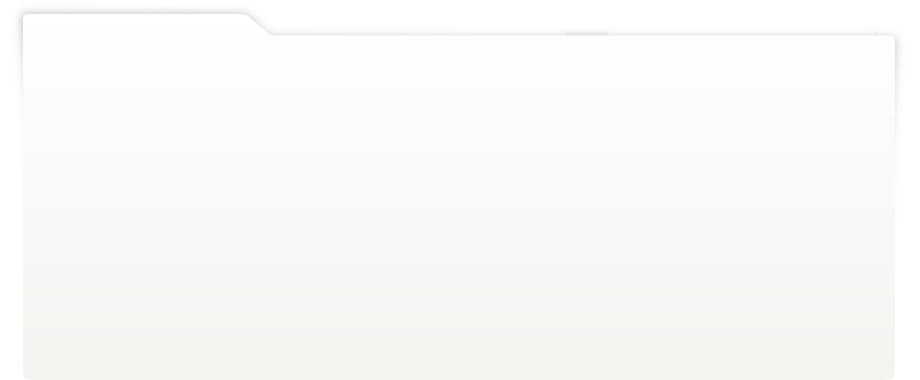
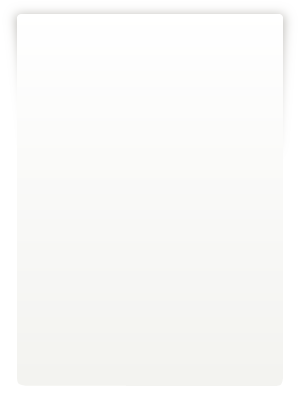
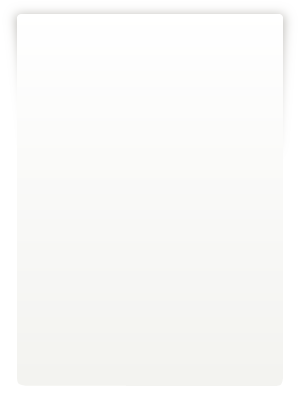
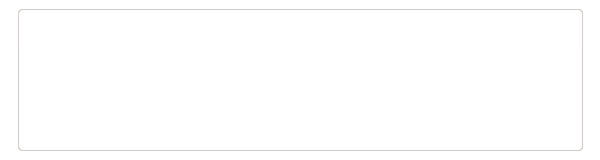
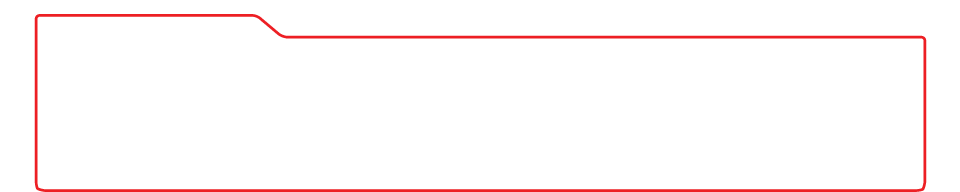
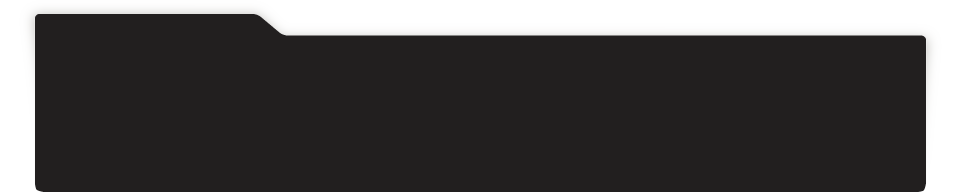
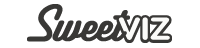
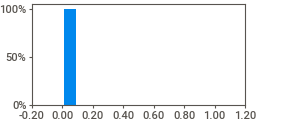
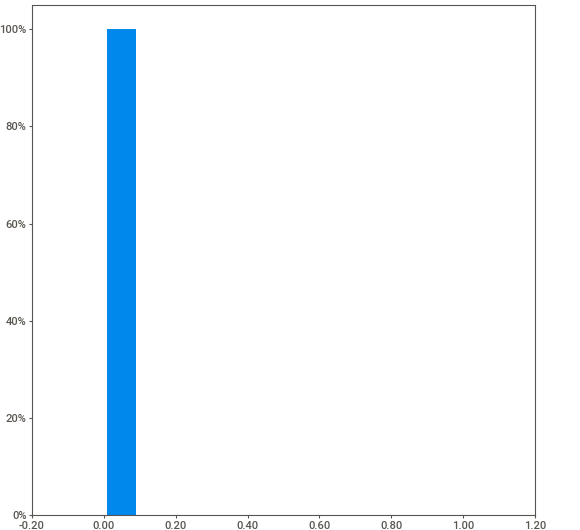
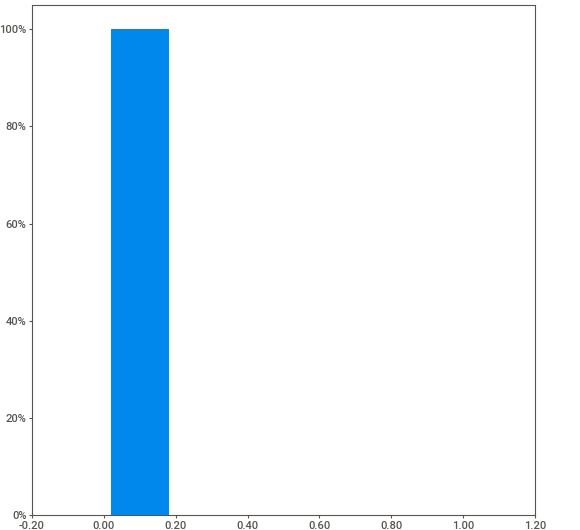
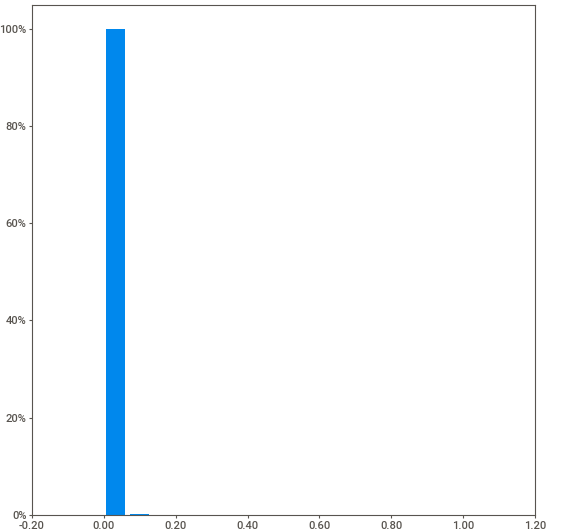
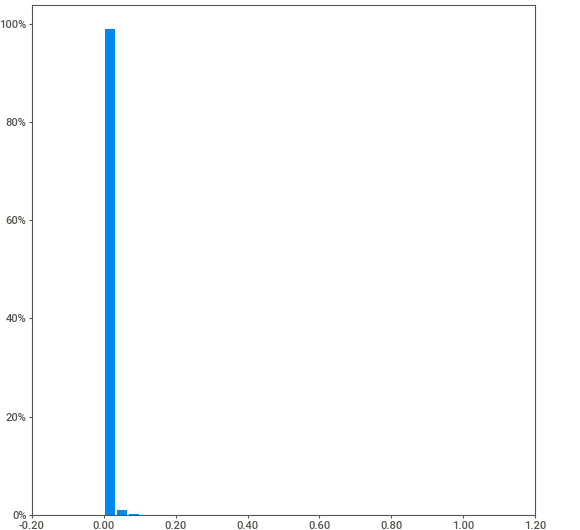
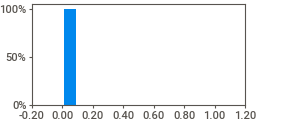
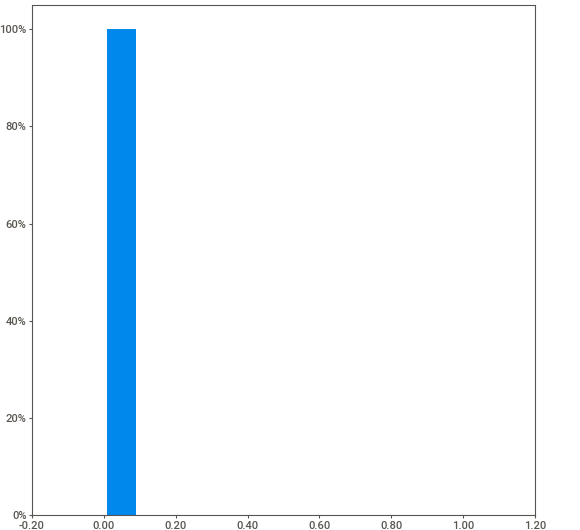
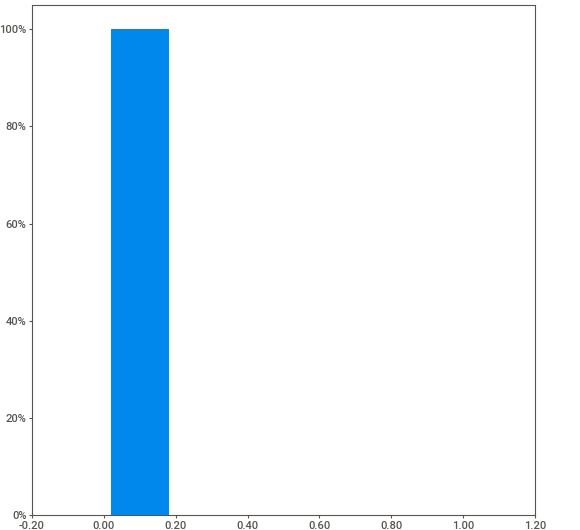
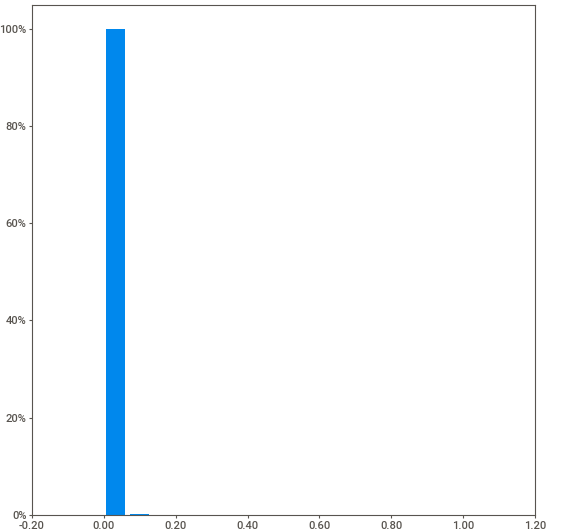
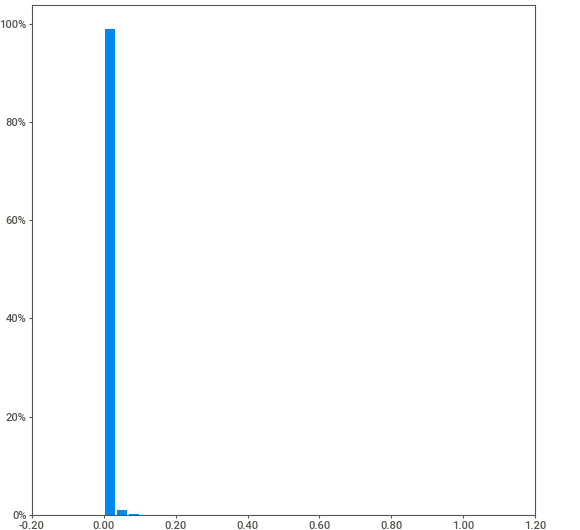
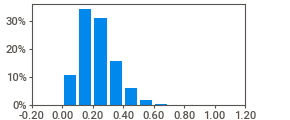
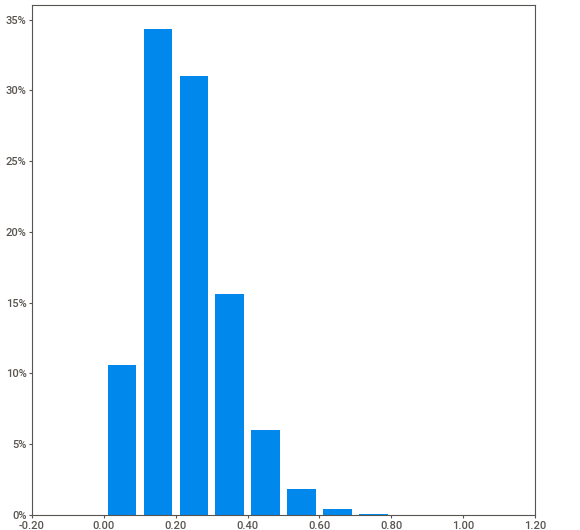
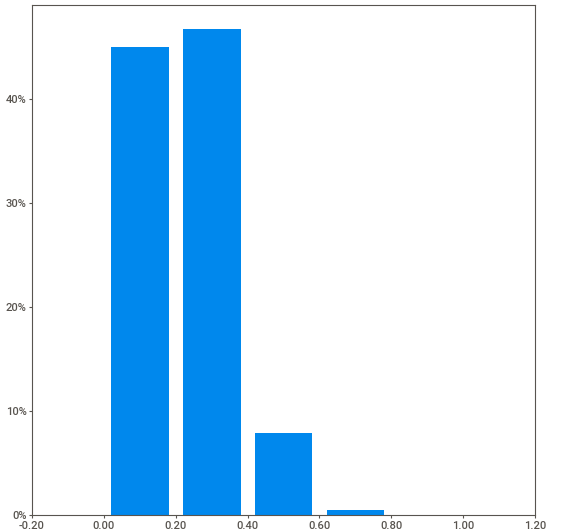
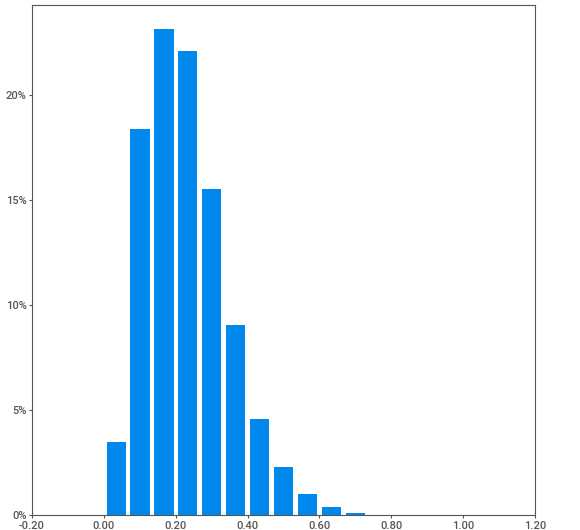
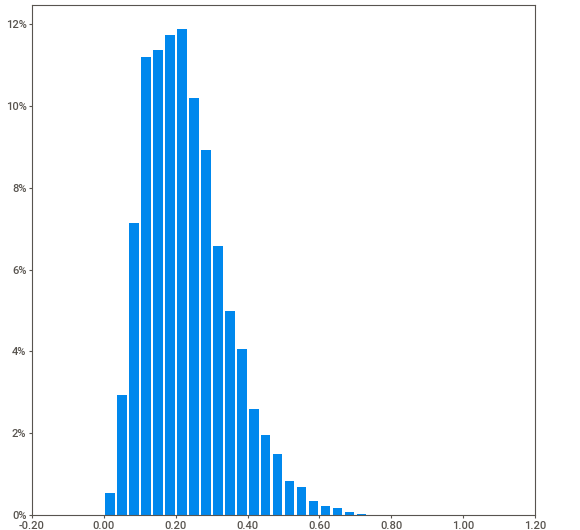
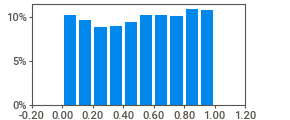
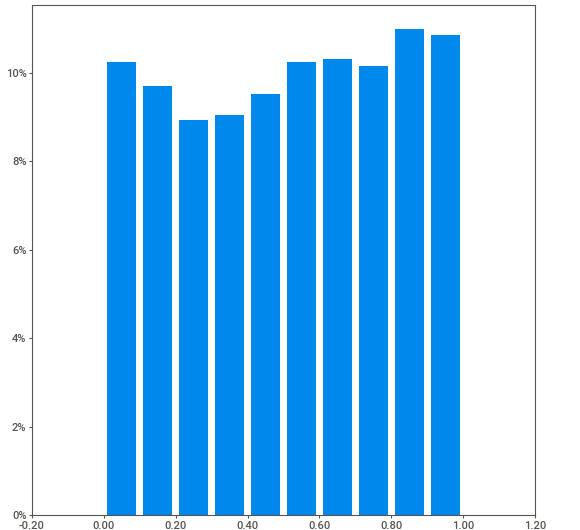
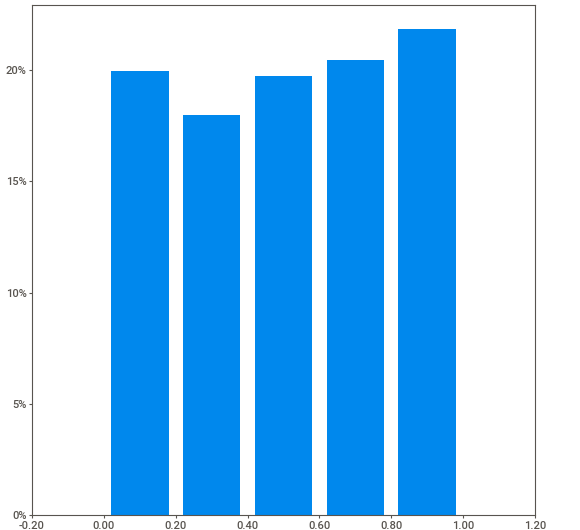
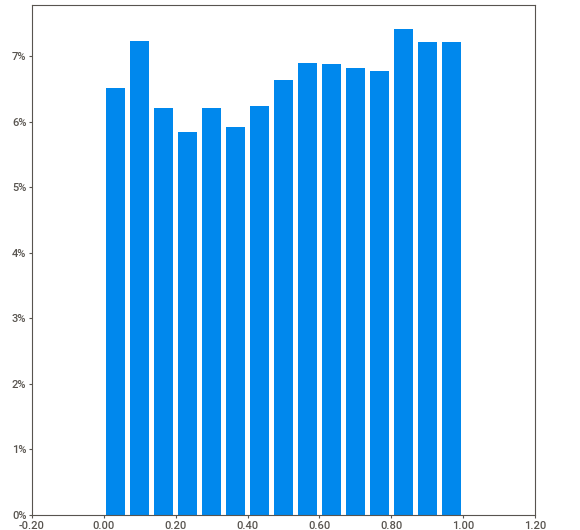
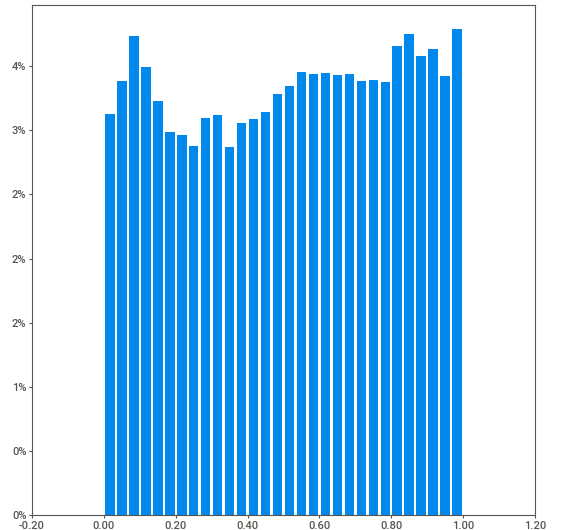
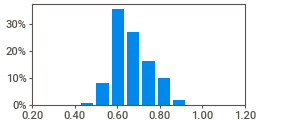
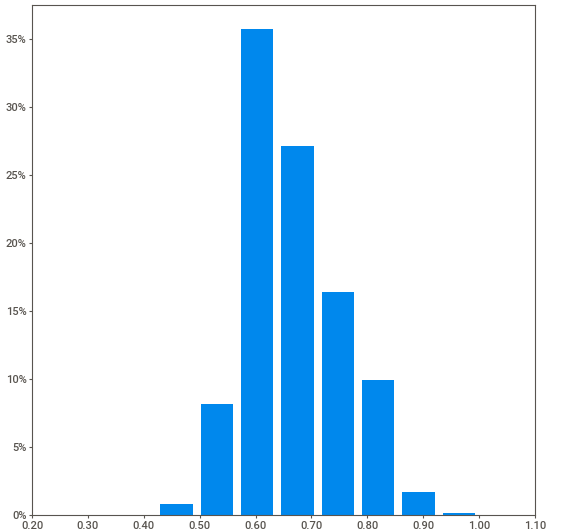
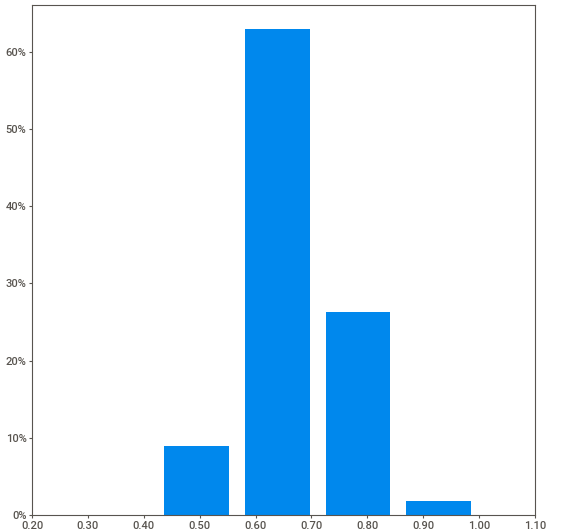
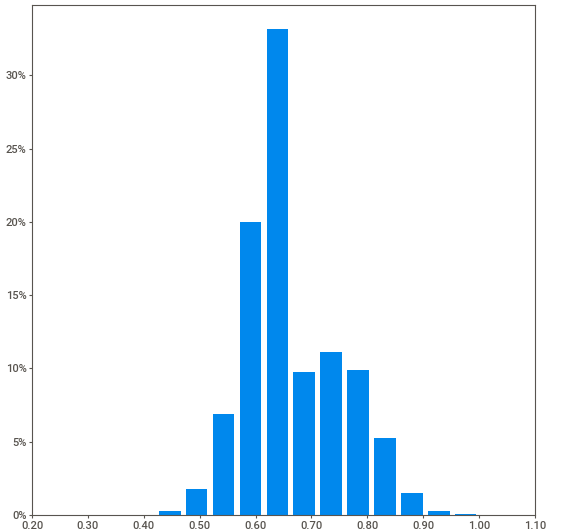
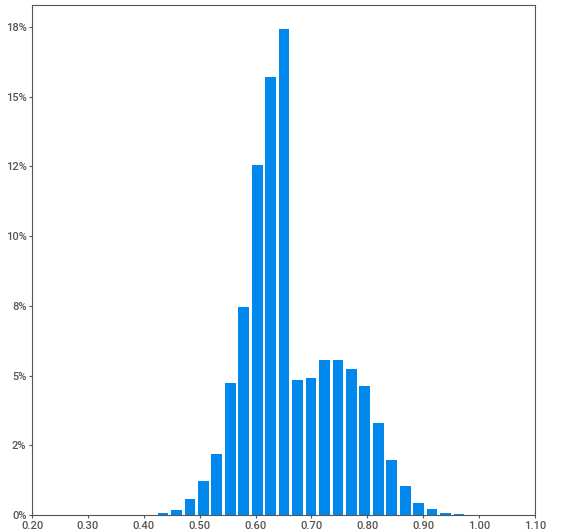
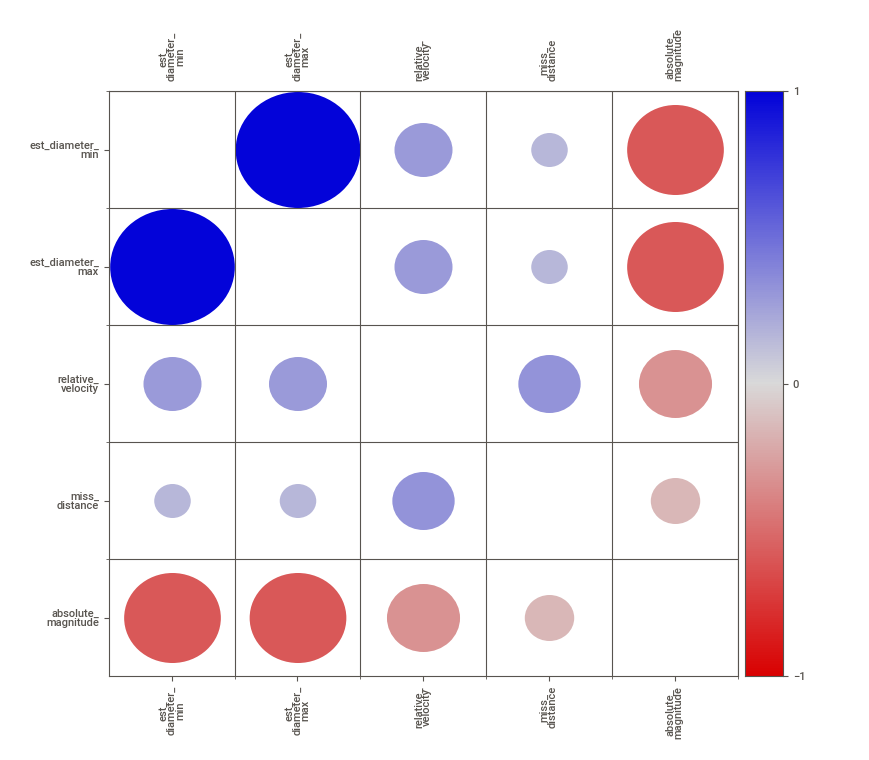
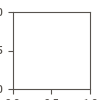

In [87]:
sv.analyze(norm_data_with_classes_upper_samled).show_notebook()


# Создание модели

In [3]:
class EasierModel(torch.nn.Module):
    def __init__(self, input_layer_size: int, output_layer_size: int):
        super(EasierModel, self).__init__()
        self.first_layer = torch.nn.Linear(
            input_layer_size,
            int(int(input_layer_size * 3))
        )
        self.first_activation = torch.nn.ReLU()
        self.output_layer = torch.nn.Linear(
            int(int(input_layer_size * 3)),
            output_layer_size
        )
        # self.output_activation = torch.nn.Sigmoid()

    def forward(self, x):
        y = self.first_layer(x)
        y = self.first_activation(y)
        y = self.output_layer(y)
        # y = self.output_activation(y)
        return y


In [175]:
X_train, X_test, y_train, y_test = train_test_split(norm_data_with_classes_under_samled, classes_under_sampled, test_size=0.1)
X_train.shape, X_test.shape, y_train.shape, y_test.shape


((15602, 5), (1734, 5), (15602,), (1734,))

In [176]:
train_ds = TensorDataset(
    torch.from_numpy(X_train.to_numpy()).type(torch.float32), 
    torch.from_numpy(y_train.to_numpy()).type(torch.float32)
)
train_dl = DataLoader(train_ds, batch_size=256, shuffle=True)


In [177]:
test_ds = TensorDataset(torch.from_numpy(X_test.to_numpy()), torch.from_numpy(y_test.to_numpy()))
test_dl = DataLoader(test_ds, batch_size=512, shuffle=True)


In [178]:
model = EasierModel(norm_data_with_classes_under_samled.columns.shape[0], 1)
loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)


In [1]:
epochs = 50
for epoch in range(epochs):
    for x_b, y_b in train_dl:
        outputs = model(x_b)
        k1, k2 = outputs.detatch().numpy().max(), outputs.detatch().numpy().min()
        loss_value = loss(outputs, y_b.long())
        loss_value.backward()
        optimizer.step()
        optimizer.zero_grad()
    print(f'Эпоха {epoch + 1}, Значение функции потерь: {loss_value.item()}, {k1, k2}')


NameError: name 'train_dl' is not defined

In [ ]:
from sklearn.metrics import f1_score
y_pred = model(torch.from_numpy(X_test.to_numpy()).type(torch.float32))
f1_score(y_test, y_pred.detach().numpy() > 0.5)


0.0

In [ ]:
y_pred.detach().numpy()


array([[0.],
       [0.],
       [0.],
       ...,
       [0.],
       [0.],
       [0.]], dtype=float32)

In [ ]:
print(classification_report(y_test, y_pred.detach().numpy() > np.median(y_pred.detach().numpy())))


              precision    recall  f1-score   support

       False       0.49      1.00      0.65       842
        True       0.00      0.00      0.00       892

    accuracy                           0.49      1734
   macro avg       0.24      0.50      0.33      1734
weighted avg       0.24      0.49      0.32      1734



c:\Users\Mike\Desktop\5semak\NLP_5_semak\NLP\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Mike\Desktop\5semak\NLP_5_semak\NLP\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Mike\Desktop\5semak\NLP_5_semak\NLP\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(resu

In [ ]:
norm_data_with_classes_under_samled.columns.shape[0]


5

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(norm_data_with_classes_upper_samled, classes_upper_sampled, test_size=0.1)
X_train.shape, X_test.shape, y_train.shape, y_test.shape


((144856, 5), (16096, 5), (144856,), (16096,))

In [ ]:
train_ds = TensorDataset(
    torch.from_numpy(X_train.to_numpy()).type(torch.float32), 
    torch.from_numpy(y_train.to_numpy()).type(torch.float32)
)
train_dl = DataLoader(train_ds, batch_size=256, shuffle=True)

test_ds = TensorDataset(
    torch.from_numpy(X_test.to_numpy()), 
    torch.from_numpy(y_test.to_numpy())
)
test_dl = DataLoader(test_ds, batch_size=256, shuffle=True)


In [ ]:
model2 = MyRegressionModel(norm_data_with_classes_under_samled.columns.shape[0], 1)
loss = torch.nn.L1Loss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)


NameError: name 'MyRegressionModel' is not defined

In [ ]:
epochs = 50
for epoch in range(epochs):
    for x_b, y_b in train_dl:
        optimizer.zero_grad()
        outputs = model(x_b)
        loss_value = loss(outputs, y_b)
        loss_value.backward()
        optimizer.step()
    print(f'Эпоха {epoch + 1}, Значение функции потерь: {loss_value.item()}, {np.unique(outputs.detach().numpy() > np.median(outputs.detach().numpy()))}')


C:\Users\Mike\AppData\Local\Temp\ipykernel_15560\2591723043.py:45: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y = self.fifth_relu(y)


Эпоха 1, Значение функции потерь: 0.49519041180610657, [False]
Эпоха 2, Значение функции потерь: 0.5160194039344788, [False]
Эпоха 3, Значение функции потерь: 0.5080006122589111, [False]
Эпоха 4, Значение функции потерь: 0.501604437828064, [False]
Эпоха 5, Значение функции потерь: 0.5096264481544495, [False]
Эпоха 6, Значение функции потерь: 0.5048286318778992, [False]
Эпоха 7, Значение функции потерь: 0.4967954754829407, [False]
Эпоха 8, Значение функции потерь: 0.496777206659317, [False]
Эпоха 9, Значение функции потерь: 0.4903410077095032, [False]
Эпоха 10, Значение функции потерь: 0.4757280945777893, [False]
Эпоха 11, Значение функции потерь: 0.5, [False]
Эпоха 12, Значение функции потерь: 0.5290616750717163, [False]
Эпоха 13, Значение функции потерь: 0.5016121864318848, [False]
Эпоха 14, Значение функции потерь: 0.49031513929367065, [False]
Эпоха 15, Значение функции потерь: 0.49837949872016907, [False]
Эпоха 16, Значение функции потерь: 0.4823053181171417, [False]
Эпоха 17, Значе

In [ ]:
from sklearn.metrics import f1_score
y_pred = model(torch.from_numpy(X_test.to_numpy()).type(torch.float32))
f1_score(y_test, y_pred.detach().numpy() > y_pred.detach().numpy().mean())


C:\Users\Mike\AppData\Local\Temp\ipykernel_15560\2591723043.py:45: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y = self.fifth_relu(y)


0.0

In [ ]:
print(classification_report(y_test, y_pred.detach().numpy() > np.median(y_pred.detach().numpy())))

              precision    recall  f1-score   support

       False       0.50      1.00      0.66      7994
        True       0.00      0.00      0.00      8102

    accuracy                           0.50     16096
   macro avg       0.25      0.50      0.33     16096
weighted avg       0.25      0.50      0.33     16096



c:\Users\Mike\Desktop\5semak\NLP_5_semak\NLP\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Mike\Desktop\5semak\NLP_5_semak\NLP\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Mike\Desktop\5semak\NLP_5_semak\NLP\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(resu

In [ ]:
knn = KNeighborsClassifier().fit(X_train, y_train)
pred = knn.predict(X_test)
print(classification_report(pred, y_test))


              precision    recall  f1-score   support

       False       0.75      0.90      0.82       729
        True       0.92      0.78      0.84      1005

    accuracy                           0.83      1734
   macro avg       0.83      0.84      0.83      1734
weighted avg       0.85      0.83      0.83      1734

